## Descripcion del problema: inbound de paquetes

Para acelerar la logística de un e-commerce, se quiere centralizar todos los productos que vende en un depósito. De forma que en el momento de compra ya tenga el producto a ser entregado y no lo tenga que ir a buscar al proveedor.

Por lo que tiene que contratar camiones para que vayan a buscar esos productos a los distintos proveedores y traerlos al depósito.

El problema está en la productividad (items ingresados / hora) del ingreso de estos paquetes al depósito una vez que llega el camión. 

Los camiones van a llegar al depósito en un horario que definimos nosotros. El depósito tiene M gates (puertas) y tiene que haber N workers para recibir esos paquetes y procesar estos camiones.

Queremos verificar que las definiciones de llegada de horario y la configuración de gates y workers de un caso real no generan una sobrecarga en la operación. Y si hay una oportunidad para abaratar costos.

Nuestro modelo consiste en los siguientes atomicos: 
- *Router*, un generador de camiones con cierta regularidad y cantidad de paquetes
- Queue, que encola estos camiones previos a ser procesados
- *Barrier*, que administra a que *Gate* enviar el camion
- *Gate*, que procesa los camiones
- *Manager*, que en base a la frecuencia de paquetes actuales si supera cierto umbral envia mensajes a las Gate
- *Transducer*, que calcua la frecuencia actual de llegada de camiones

<p align="center">
    <img src="modelo_conceptual.png"  width="700"/>
</p>

El sistema se vuelve interesante al considerar que en cada momento las *Gate* pueden estar inactivas por distintas razones o tener distinta cantidad de trabajadores en cada momento del dia y por lo tanto distintas velociaddes de procesamiento. Por lo tanto podemos considerar distintas propiedades:

- ¿A que frecuencia de llegada de camiones se satura el sistema?
- ¿Con qué distribución y cantidad de paquetes?
- ¿Cómo impacta el umbral del Manager a el comportamiento del sistema?
- ¿Cómo cambia el tiempo de procesado en distintos momentos del dia?

## Configuración

In [71]:
import pandas as pd
import scipy as sp
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,10)

In [130]:
from pathlib import Path

SED_HOME = Path.home().joinpath('Documents').joinpath('sed')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

CDPP_BIN = BASE_BIN.joinpath('cd++')
DRAWLOG_BIN = BASE_BIN.joinpath('drawlog')

TP = CDPP_EXAMPLES.joinpath("dc-sed-tp1-2022")
TP_SRC = TP.joinpath('src')
TP_BIN = TP.joinpath('src/bin')

In [131]:
def make():
    command = f'cd {TP_SRC} && make > delete.out'
    os.system(command)

def run(ma_name, exp_name, hours=120):
    command = str(TP_BIN) + f"/cd++ -m {str(TP)}/model/{ma_name}.ma -l {str(TP)}/data/{exp_name}.log -o {str(TP)}/data/{exp_name}.out -t {hours}:00:00:000 > delete.out" 
    os.system(command)  

def read_out(out_name):
    with open(f"../data/{out_name}.out") as f:
        lines = f.readlines()
        lines = list(filter(lambda x: "out" in x, lines))
        lines = list(map(lambda x: x.split("[")[1].split("]")[0], lines))

        df = pd.DataFrame([x.split(', ') for x in lines])
    df.columns = ['id', 'arrival_time', "assigned_time", "out_time", "nA", "nB", "nC", 'id_gate', 'extra_workers']
    df = df.astype(np.float64)
    df['arrival_hour_modulo'] = df['arrival_time']/3600 % 24
    df['arrival_hour'] = df['arrival_time']/3600
    df["total_time"] = df["out_time"] - df["arrival_time"] 
    df['processing_time'] = df['out_time'] - df['assigned_time']
    df['waiting_time'] = df['assigned_time'] - df['arrival_time']
    return df

def change_param(ma_name, key, value):
    with open(f'{str(TP)}/model/{ma_name}.ma', 'r') as file:
        # read a list of lines into data
        data = file.readlines()

    for i,line in enumerate(data):
        if key in line:
            data[i] = key + " : " + str(value) + '\n'

    # and write everything back
    with open(f'{str(TP)}/model/{ma_name}.ma', 'w') as file:
        file.writelines( data )

# conversion VTime a float
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

make()

## Router

Cada camion contiene 3 tipos de paquetes. En la vida real estos son electronicos, comestibles y otros. El router genera cada uno de los camiones por medio de distribuciones ```Poisson``` con promedio de 50 paquetes cada una.

Mas interesante es la distribucion de llegada de camiones. Decidimos modelar esto como que en cada dia la llegada de camiones sigue una gaussiana recortada en los extremos que representan el periodo de inactividad donde en la vida real no llegan paquetes. La cantidad de camiones en un mismo dia tambien sigue una gaussiana, de esta forma puede que algunos dias lleguen mas camiones que otros. Un parametro del atomico  ```meanTrucks``` determina este promedio de la gaussiana.


En la siguiente celda mostramos un histograma que muestra como llegan los paquetes a lo largo del tiempo para un promedio de 150 camiones por dia

Text(0, 0.5, 'n de camiones')

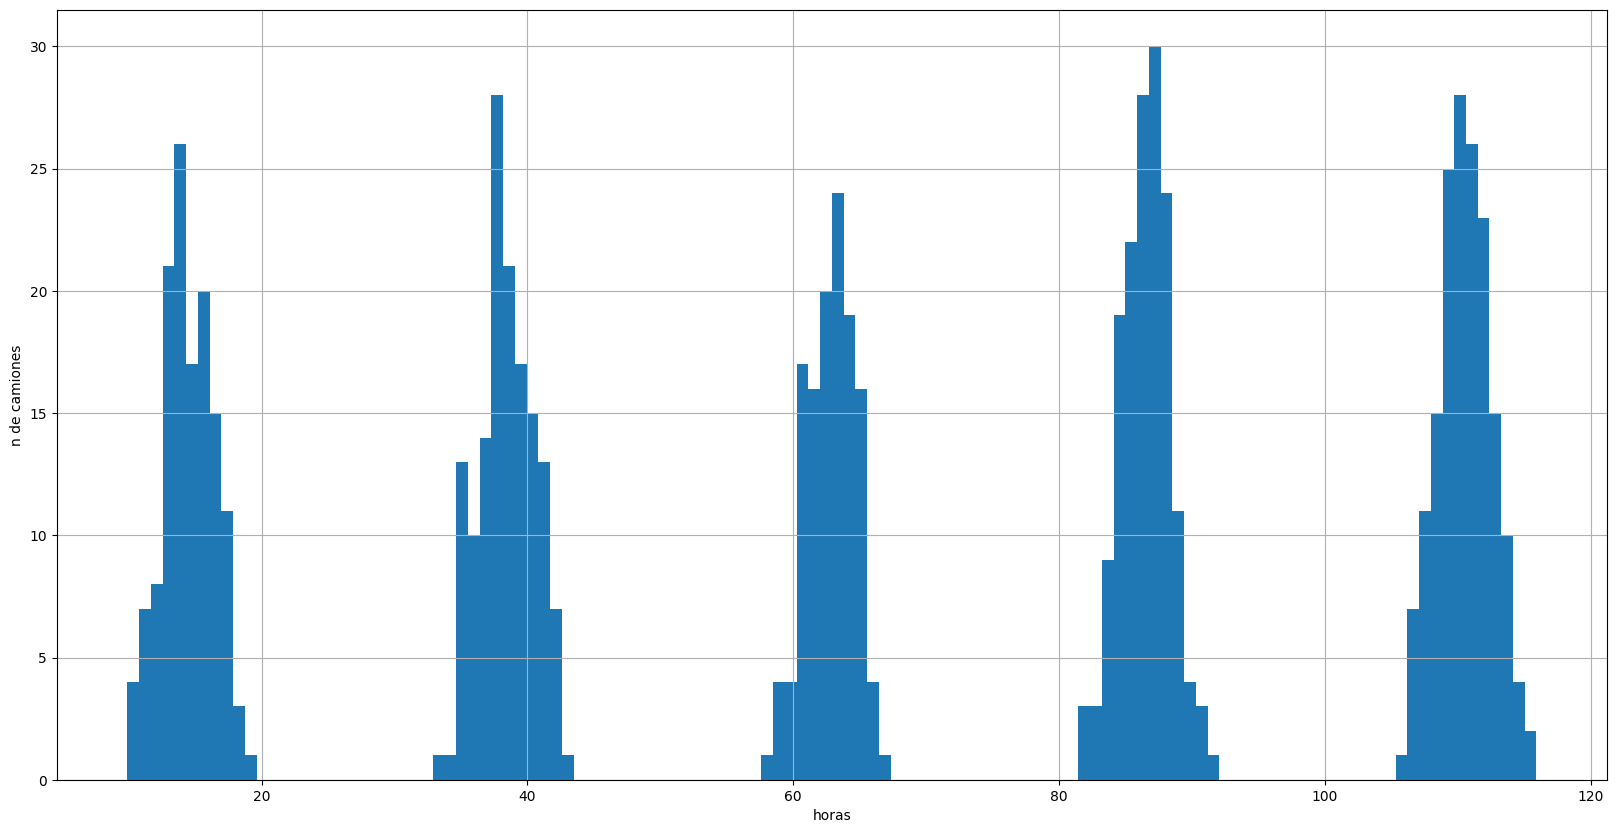

In [106]:
run("top_150_sin_manager","truck_distribution")
df = read_out("truck_distribution")
ax = (df['arrival_time']/3600).hist(bins=120)
ax.set_xlabel("horas")
ax.set_ylabel("n de camiones")

## Barrier

La barrera se encarga de asignar los vehículos que se van encolando en la entrada a las Gates abiertas. Mantiene un status de cada Gate y a medida que las Gates se van liberando, va asignando los vehículos.

<p align="center">
    <img src="Barrier.png"  width="400"/>
</p>

## Gate

Una pregunta que nos hicimos es como modelamos el tiempo de procesado del camion. En la realidad las gates tienen cierta cantidad de trabajadores que procesan el camion. Hay trabajadores turno mañana y turno noche. 

Internamente dentro de la gate simulamos el proceso de multiples trabajadores procesando gates en paralelo. El tiempo procesado de cada paquete por un trabajador sigue una gaussiana que depende del tipo de paquete.

A su vez, cada gate tiene un tiempo de actividad en el que se encuentra disponible para procesar camiones y un tiempo en el que se encuentra ```UNAVAILABLE``` y por lo tanto no puede procesar camiones.

Las gates tienen ciertos periodos en donde tienen distinta cantidad de trabajadores (ademas de poder estar cerradas)
- De 9 a 12: 5 trabajadores
- De 12 a 18: 4 trabajadores
- De 18 a 21: 5 trabajadores
- Otro periodo: 2 trabajadores

A grandes rasgos la gate tiene 3 estados. 
- ```UNAVAILABLE```. Cuando la gate se encuentra cerrada
- ```BUSY```. Cuando la gate se encuentra procesando un paquete
- ```FREE``` Cuando la gate se encuentra disponible

<p align="center">
    <img src="gate.png"  width="700"/>
</p>

Hay ciertas sutilezas involucradas para mantenerse abierto una vez que te levanto el manger. En resumidas cuentas cuando te levanta el manager hay que ser cuidadoso para que no se vaya a UNAVAILABLE inmediatamente ya que se encuentra fuera de horario.

Otra cosa que modelamos es que cuando el manager envia un mensaje a una gate abierta le de un "boost" a su cantidad de workers agregando 3. Este boost va decayendo exponencialmente a medida que pasa el tiempo. Notar que no modelamos esots boost como acumulativos si no que un boost anula el anterior.

En nuestro sistema "default" tendremos 10 gates. 4 abiertas de 9 a 21 y 6 abiertas de 18 a 21.

### Analisis del tiempo de procesado en base a la cantidad de workers

Un analisis previo que hicimos es ver como afecta el tiempo de procesado cuando se tiene distinta cantidad de workers.

El tiempo de procesado es una variable aleatoria por lo que vemos las distribuciones para distinta cantidad de workers

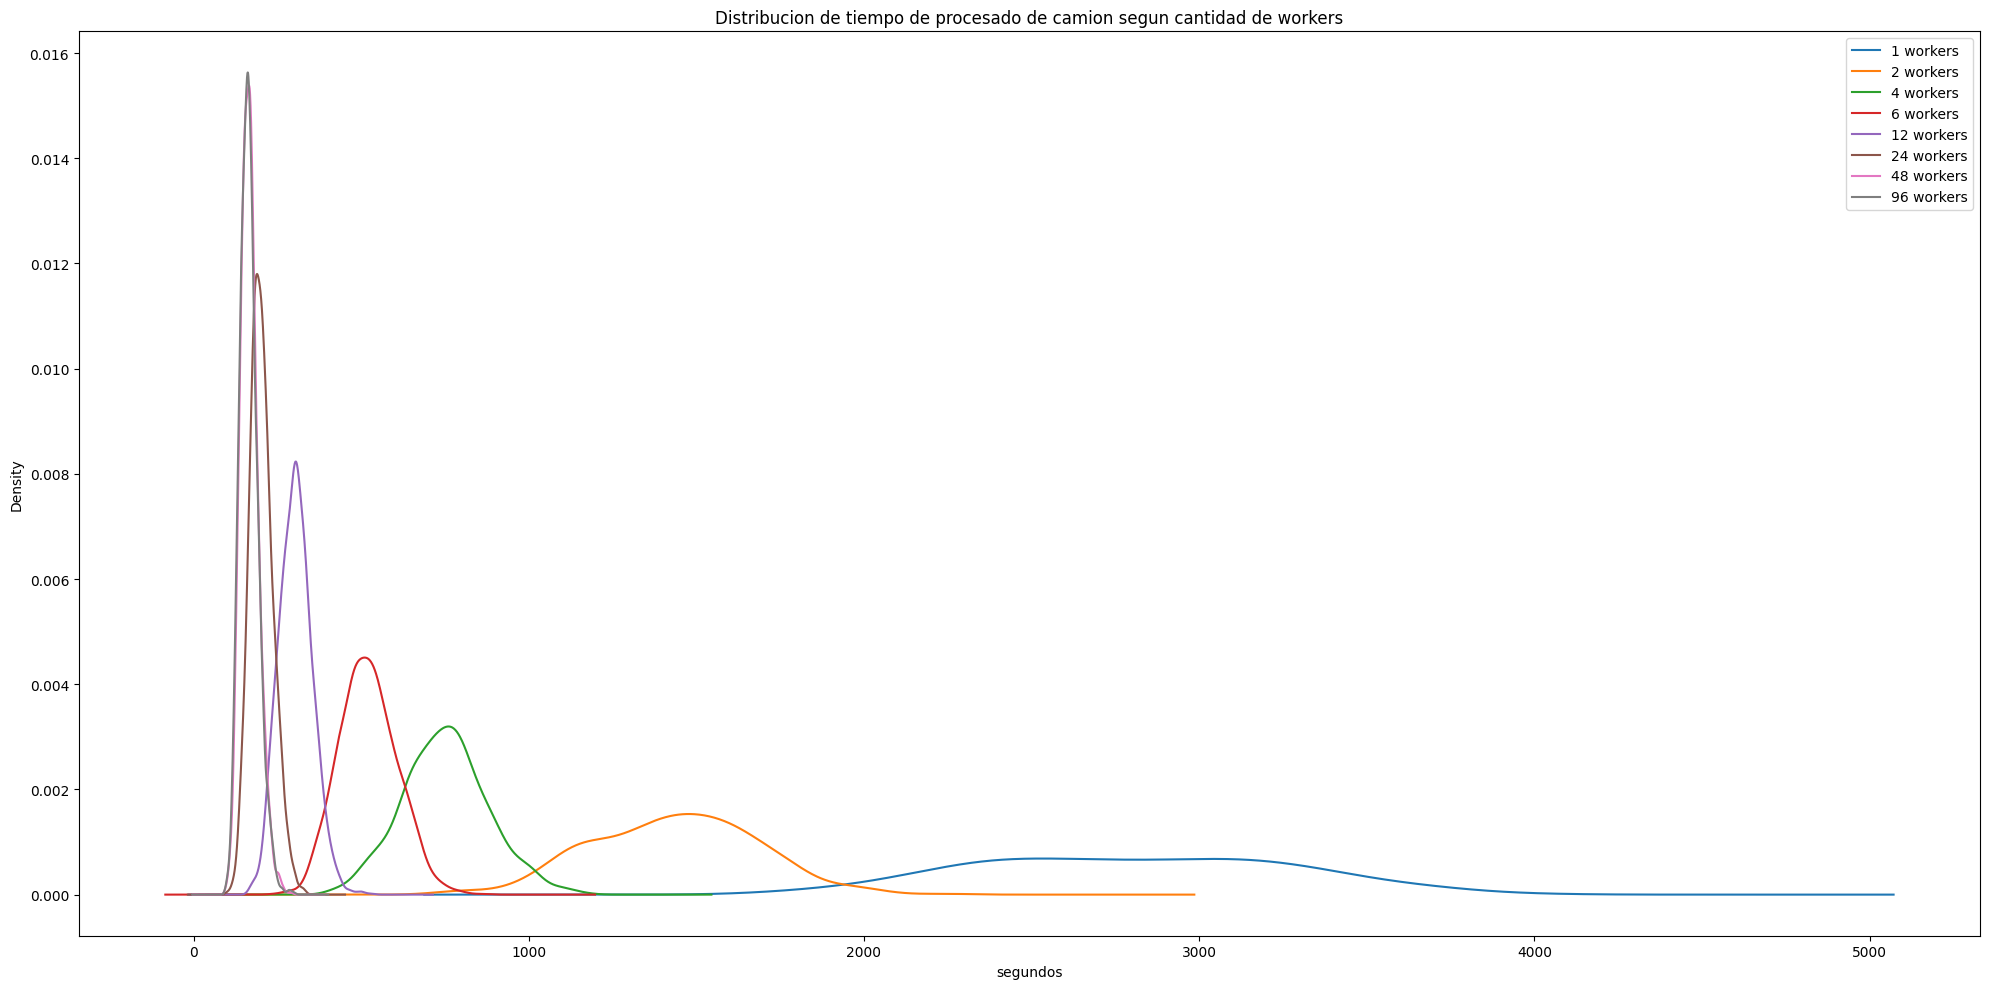

In [107]:
dfs = []
for i in (1,2,4,6,12,24,48,96):
    change_param("gates_iguales","startWorkers",i)
    run("gates_iguales",f"gates_iguales_{i}_worker")
    dfs.append((i, read_out(f"gates_iguales_{i}_worker")))

ax.set_xlabel("horas")
ax.set_ylabel("n de camiones")
for (n,df_worker) in dfs:
    df_worker["processing_time"].plot.kde(label=str(n) + " workers")
plt.xlabel("segundos")
plt.title('Distribucion de tiempo de procesado de camion segun cantidad de workers')
plt.tight_layout()
plt.legend()


Vemos que para cantidades de workers << paquetes por camion el tiempo decrece inversamente con la cantidad de workers. Aunque vemos que a partir de 48 workers el tiempo de procesamiento no escala mucho más. Esto es porque los workers se estarían chocando entre ellos para poder bajar los paquetes del camión.

También analizamos como cambia el througput con distinta cantidad de workers. Es decir la cantidad de camiones por hora que se pueden procesar con esa cantidad de workers

Text(0.5, 1.0, 'Camiones por hora segun cantidad de workers')

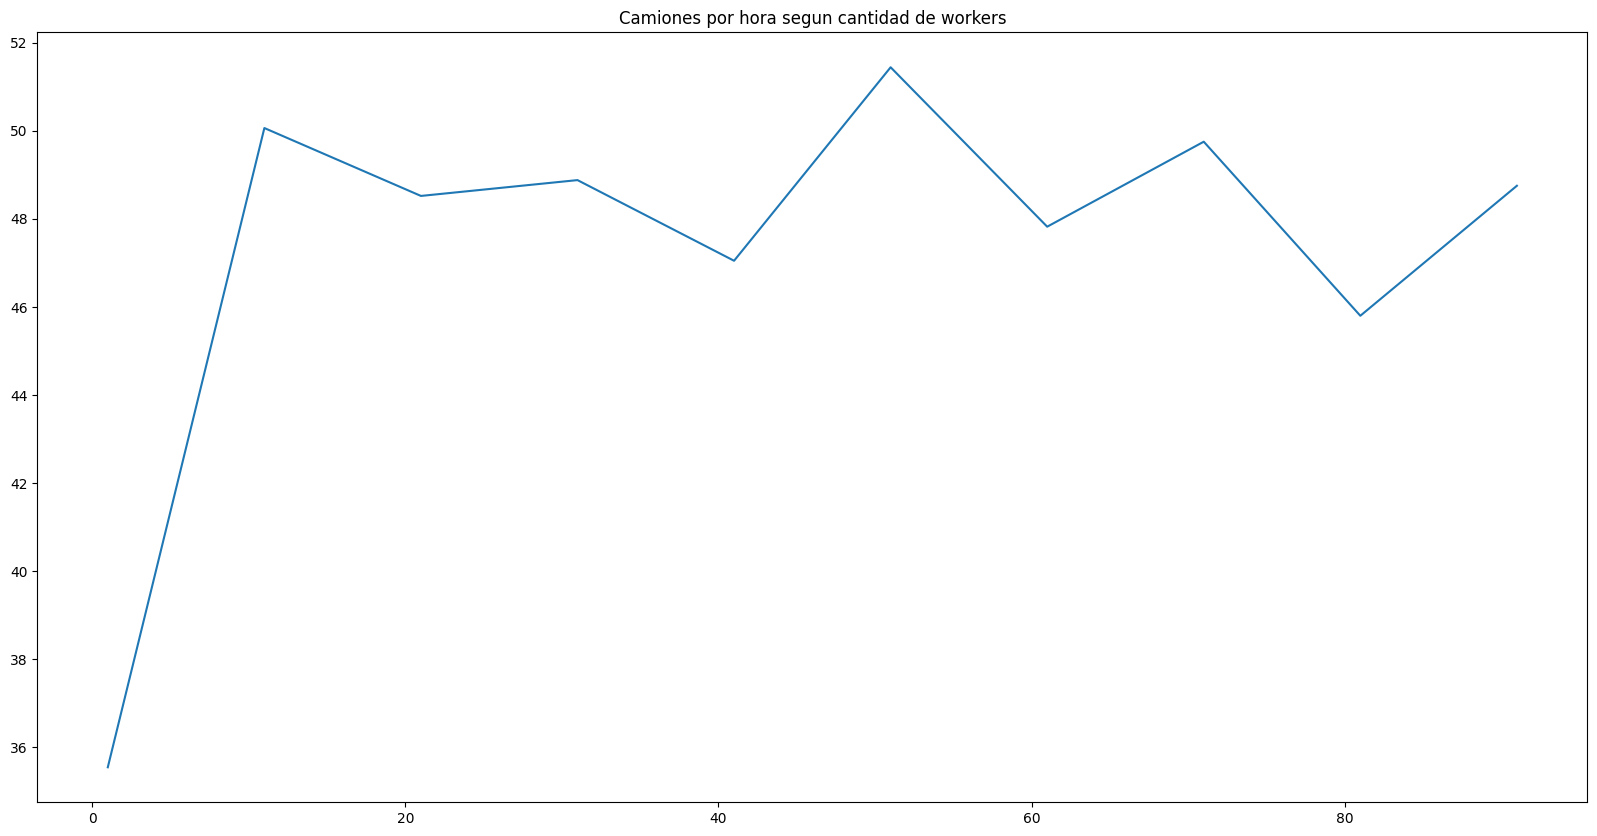

In [104]:
data = []
change_param("gates_iguales","meanRoutes",500)
for i in range(1,100,10):
    values = []
    for j in (1,2,3):
        change_param("gates_iguales","startWorkers",i)
        run("gates_iguales",f"productividad", hours=24)
        df = read_out(f"productividad")
        values.append(len(df.index) / (df['arrival_hour'].max() - df['arrival_hour'].min()))
    data.append((i, sum(values)/3))
        
plt.plot(*zip(*data))
plt.title('Camiones por hora segun cantidad de workers')

Como sospechabamos, la efectividad de agregar mas trabajadores disminuye rapidamente cuando se tiene una gran cantidad de workers acercandose a aprox 50 camiones/horas. Naturalmente en nuestro modelo la cantidad de workers varia en valores pequeños pero resultaba interesante observar el comportamiento para grandes cantidades de trabajadores.

Ademas esto sirve para obtener una cota superior a la cantidad de camiones por dia que pueden llegar para que no sature:

$$ \text{cota saturacion} = \sum_{\text{gate}} 50\text{ camiones/hora} \cdot \text{tiempo activo(gate)}))$$

Con 10 gates abiertas las 24 horas esto equivaldria a 5280 camiones por dia

## Manager

El manager es un atomico que en base a throughput del sistema de la cola de camiones decide enviar una señal a todas las gates que afecta su comportamiento.
La idea de esto es que, en caso de que se supere cierto umbral, se activen gates o se agreguen trabajadores a las gates para asi mantener la performance del sistema dentro de limites aceptables y evitar la saturacion.

Como ya vimos, al recibir un mensaje, se abren las gates cerradas y se potencian las gates que ya se encuentran abiertas.

## Comportamiento sin manager

### 150 camiones por dia. Sin manager

A continuacion mostramos el comportamiento del modelo sin intervencion del manager con 150 camiones en promedio por dia. La simulacion corresponde a 4 dias. En algunos graficos hacemos un moving average para reducir el ruido en los graficos

In [108]:
run("top_150_sin_manager",f"top_150_sin_manager")
df = read_out(f"top_150_sin_manager")

df.head()

,id,arrival_time,assigned_time,out_time,nA,nB,nC,id_gate,extra_workers,arrival_hour_modulo,arrival_hour,total_time,processing_time,waiting_time
0,0.0,37226.4,37227.4,37924.7,56.0,50.0,51.0,1.0,0.0,10.340667,10.340667,698.3,697.3,1.0
1,1.0,37574.0,37575.1,38211.1,48.0,39.0,40.0,2.0,0.0,10.437222,10.437222,637.1,636.0,1.1
2,2.0,39112.7,39113.7,39684.3,49.0,37.0,64.0,1.0,0.0,10.864639,10.864639,571.6,570.6,1.0
3,4.0,39698.6,39699.6,40057.0,30.0,46.0,53.0,1.0,0.0,11.027389,11.027389,358.4,357.4,1.0
4,3.0,39650.5,39651.6,40447.2,63.0,43.0,45.0,2.0,0.0,11.014028,11.014028,796.7,795.6,1.1


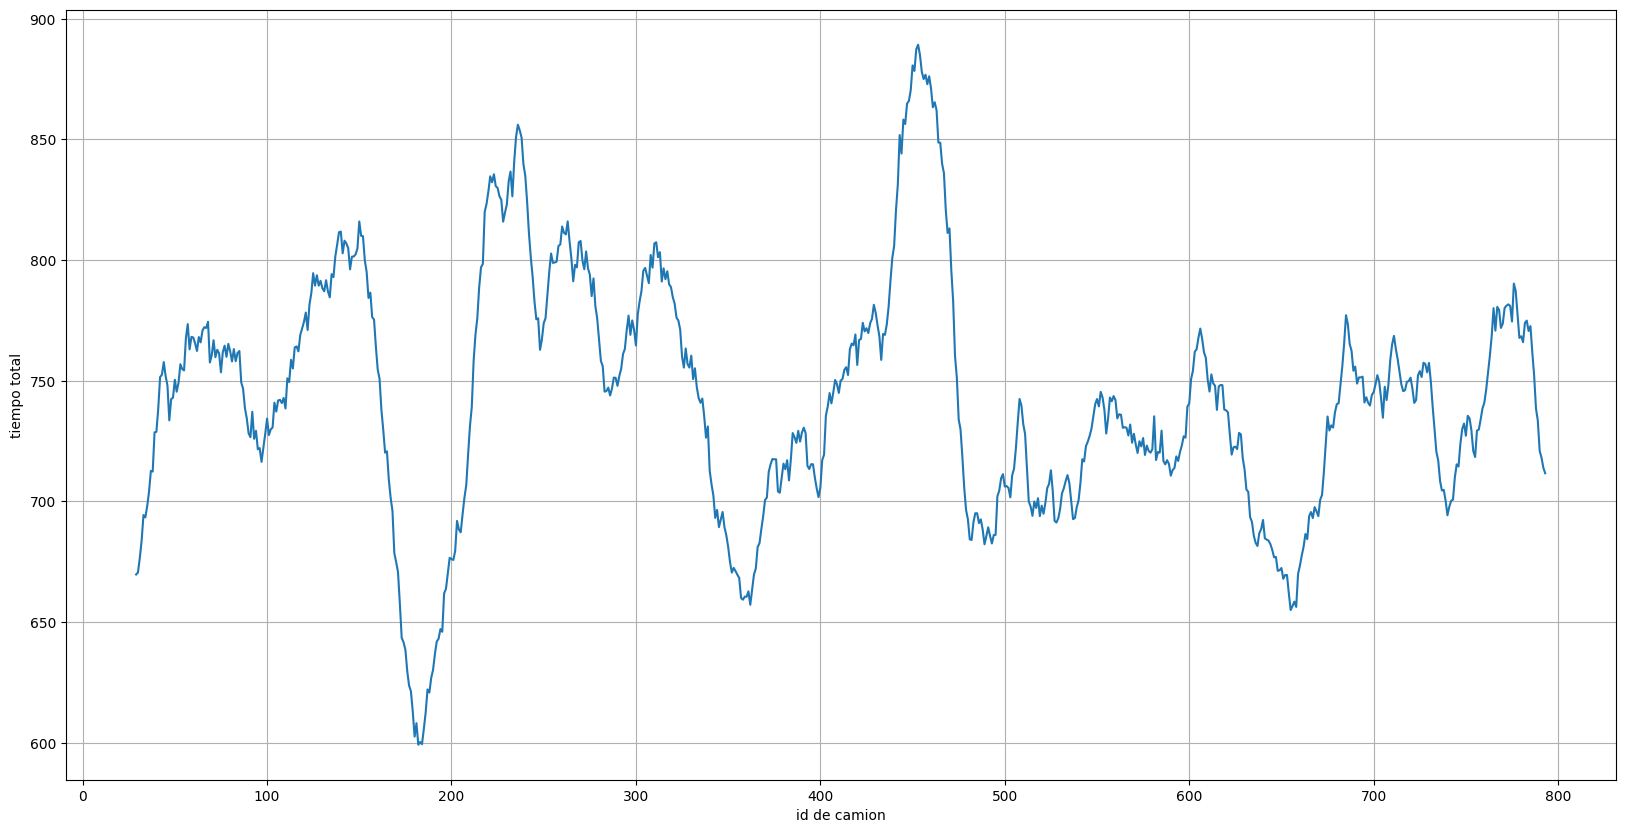

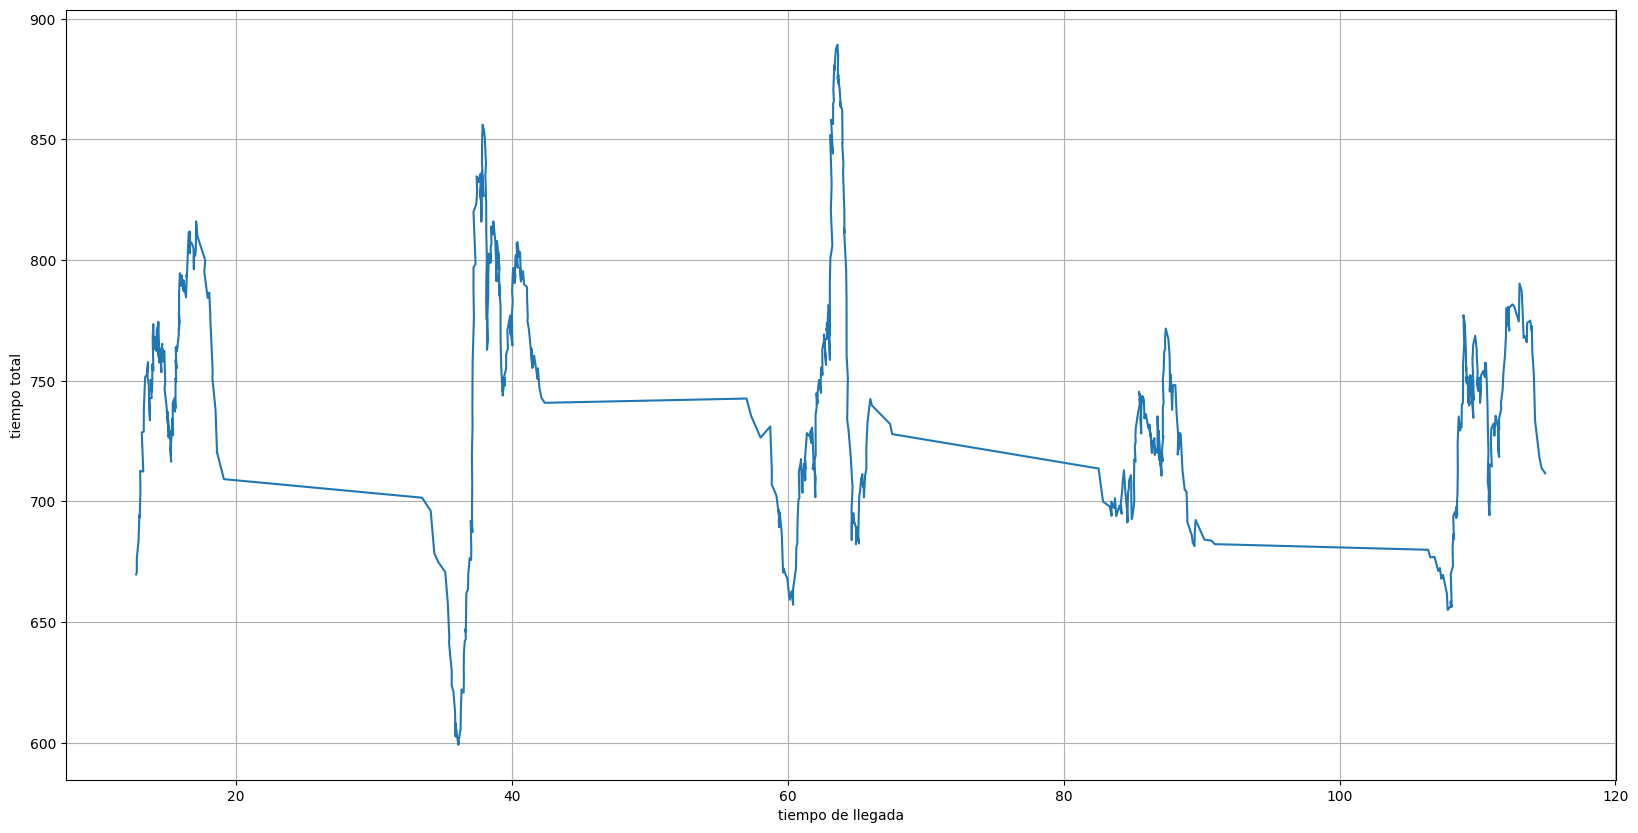

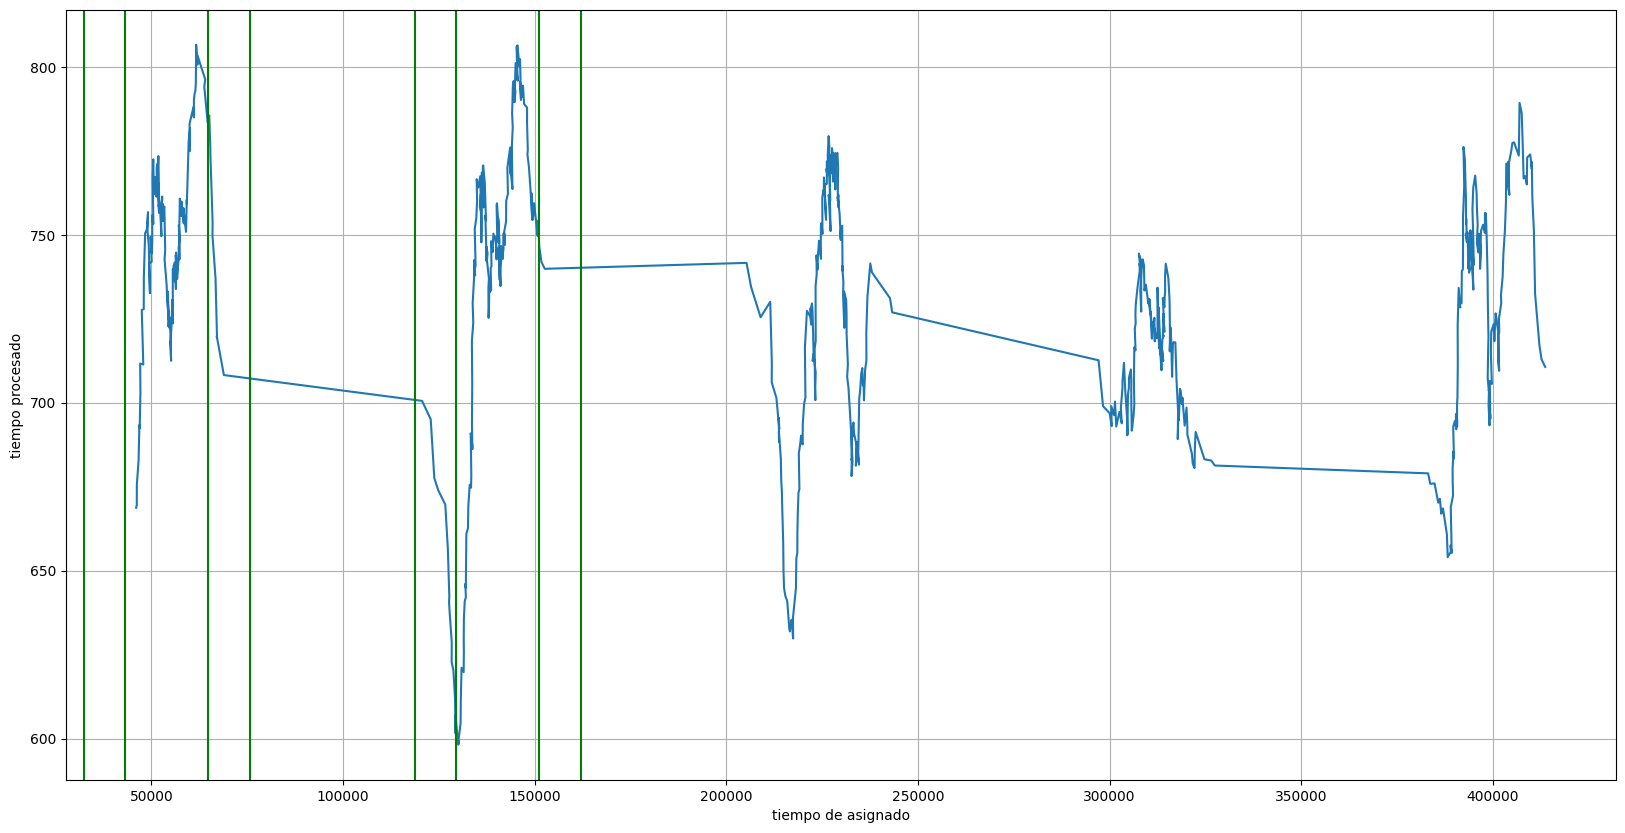

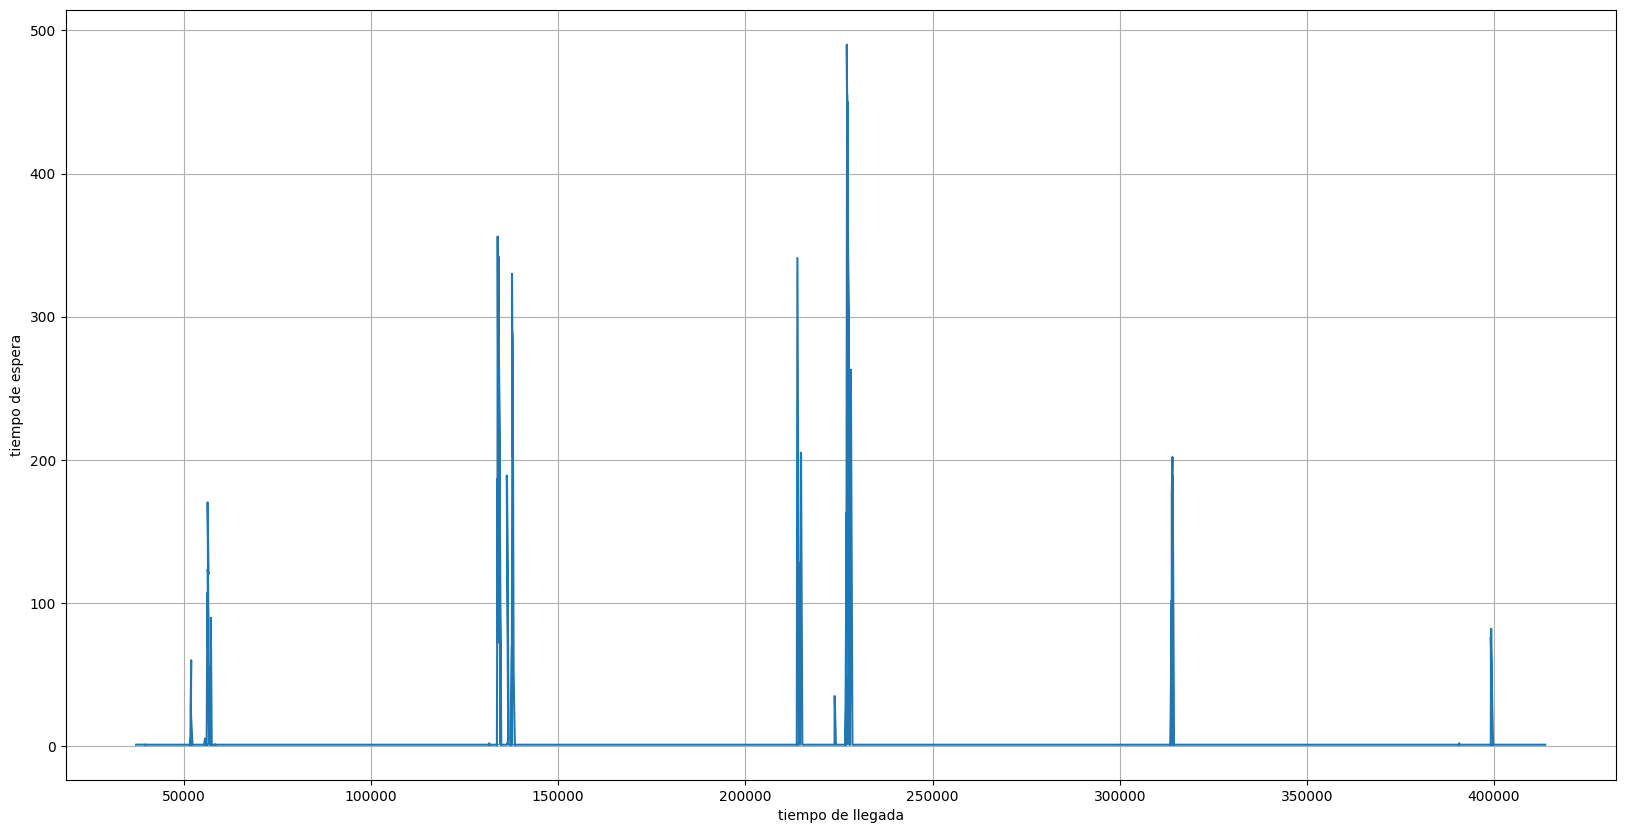

In [113]:
total_time = df['total_time']
total_time = total_time.rolling(window=30).mean()

processing_time = df['processing_time']
processing_time = processing_time.rolling(window=30).mean()

plt.plot(total_time, )
plt.grid()
plt.xlabel("id de camion")
plt.ylabel("tiempo total")
plt.show()

plt.plot(df["arrival_hour"],total_time )
plt.grid()
plt.ylabel("tiempo total")
plt.xlabel("tiempo de llegada")
plt.show()

plt.plot(df["assigned_time"],processing_time )
plt.ylabel("tiempo procesado")
plt.xlabel("tiempo de asignado")
plt.grid()
for t in [9,12,18,21,9+24,12+24,18+24,21+24]:
    plt.axvline(x = t*3600, color = 'g')

plt.show()

plt.plot(df["arrival_time"] , df["waiting_time"])
plt.ylabel("tiempo de espera")
plt.xlabel("tiempo de llegada")
plt.grid()
plt.show()

Vemos que hay un pico fuerte alrededor de las 2 de la tarde del segundo dia y tercer día. Esto corresponde al momento donde se tienen mas gates abiertas pero con menos trabajadores cada una por lo que tiene sentido que cada gate sea mas lenta. Tambien es interesante que parece ser que hay un pico en el tiempo de espera por lo que parace ser que el sistema parece estar procesdando camiones usando todas las gates y esto resulta mas lento que el throughput del router.

Tambien es interesante analizar la latencia. Es decir cuantos camiones termian de procesarse por unidad de tiempo y como cambia con los cambios de trabajadores

Para este analisis ignoramos valores muy altos que probablemente se deban al cambio de dia

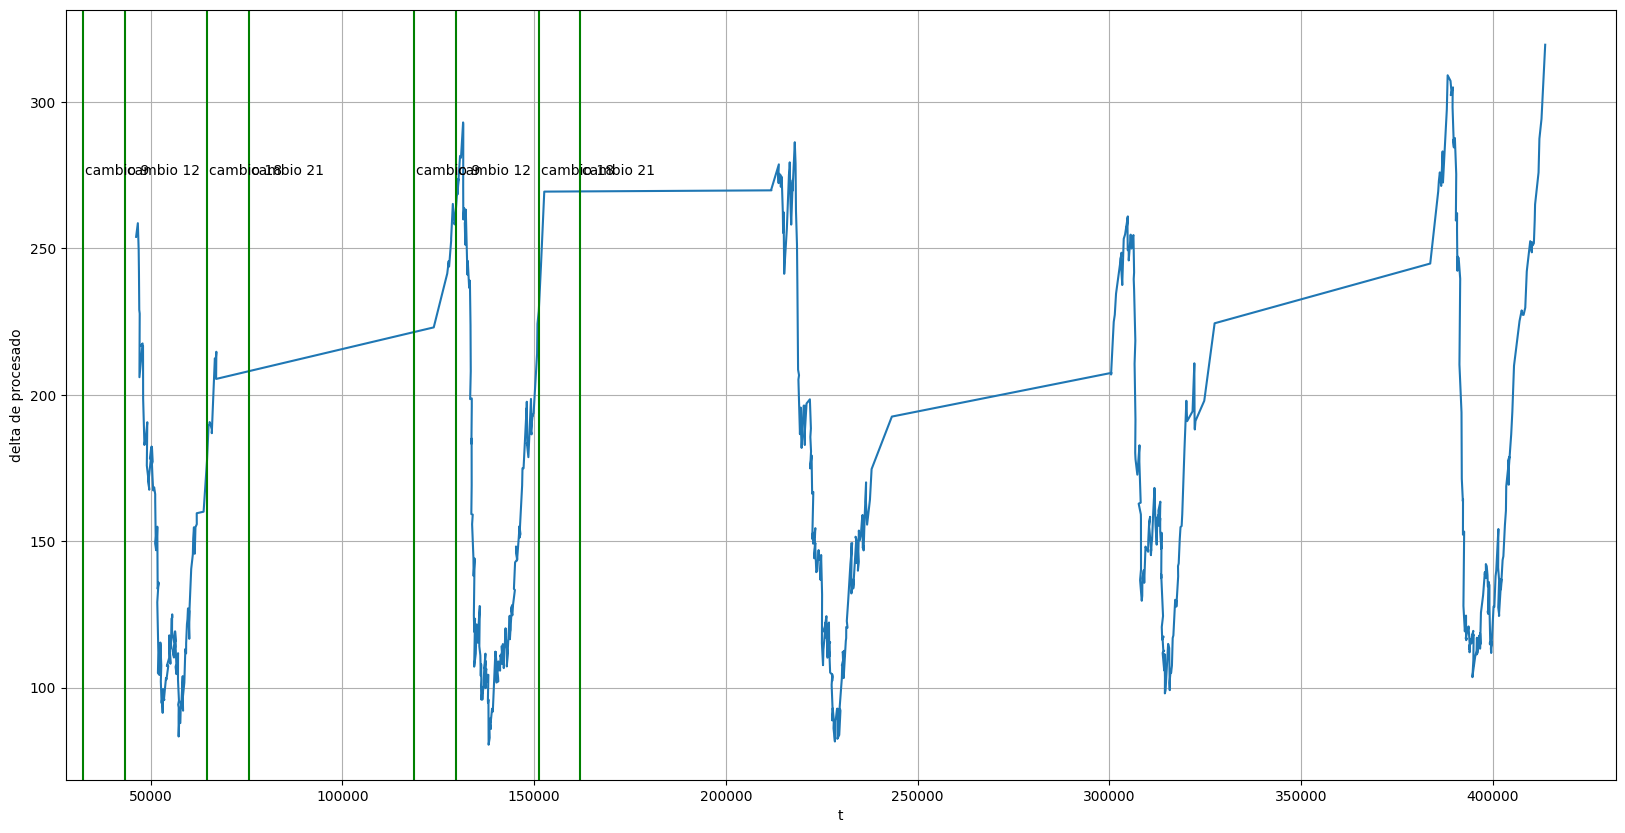

In [114]:
out_time = df["out_time"]
out_time = out_time.sort_values()
out_time = out_time.diff()
out_time = out_time[1:]

mask = out_time<1000
out_time = out_time[mask]
t = df["assigned_time"][1:]
t = t[mask]
out_time = out_time.rolling(window=30).mean()

plt.plot(t, out_time )
plt.ylabel("delta de procesado")
plt.xlabel("t")
for m in [9,12,18,21,9+24,12+24,18+24,21+24]:
    plt.axvline(x = m*3600, color = 'g', label=m)
    plt.text(m*3600 + 500.1,275, "cambio " + str(m%24))


plt.grid()
plt.show()

Esto muestra que el sistema tiene una latencia drasticamente mejor en estos periodos de mas gates abiertas con menos trabajadores auqnue el tiempo de procesado de cada paquete aumenta fuertemente tambien (como se ve en los graficos anteriores).

### 250 camiones por dia. Sin manager

Podemos intentar incrementar fuertemente la cantidad de camiones para saturar el sistema. A continuacion mostramos 4 dias con 500 camiones por dia

In [121]:
run("top_250_sin_manager",f"top_250_sin_manager")
df = read_out(f"top_250_sin_manager")

df.head()

,id,arrival_time,assigned_time,out_time,nA,nB,nC,id_gate,extra_workers,arrival_hour_modulo,arrival_hour,total_time,processing_time,waiting_time
0,0.0,33586.9,33587.9,34181.9,52.0,41.0,42.0,1.0,0.0,9.329694,9.329694,595.0,594.0,1.0
1,1.0,34128.3,34129.3,34760.0,48.0,44.0,52.0,2.0,0.0,9.480083,9.480083,631.7,630.7,1.0
2,2.0,34567.6,34568.6,35244.6,54.0,50.0,46.0,1.0,0.0,9.602111,9.602111,677.0,676.0,1.0
3,3.0,34828.5,34829.5,35387.6,39.0,43.0,55.0,2.0,0.0,9.674583,9.674583,559.1,558.1,1.0
4,4.0,35813.9,35814.9,36354.0,52.0,42.0,45.0,1.0,0.0,9.948306,9.948306,540.1,539.1,1.0


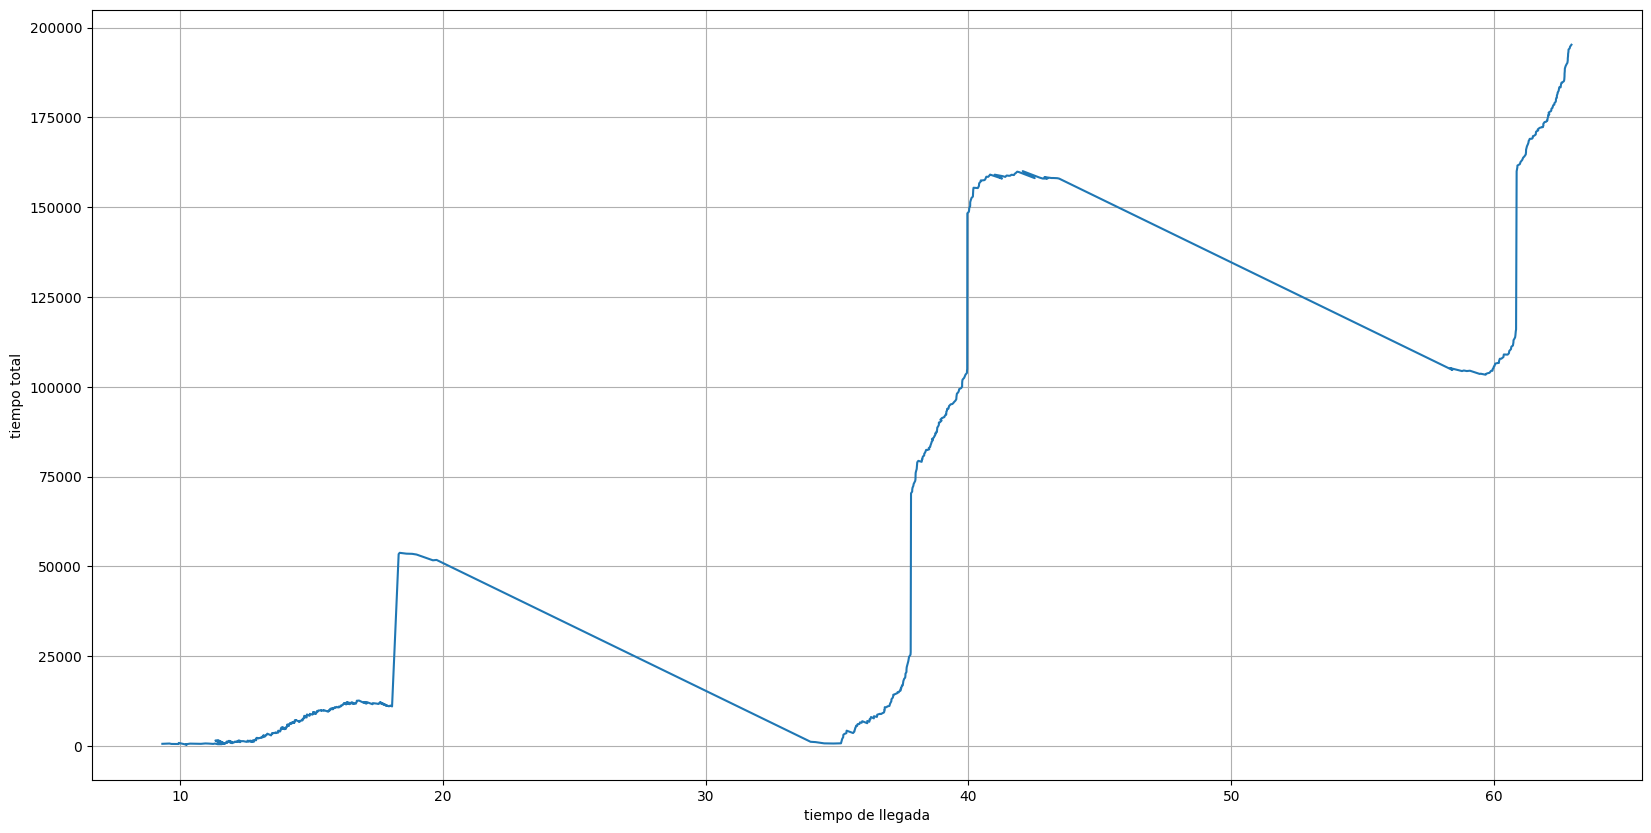

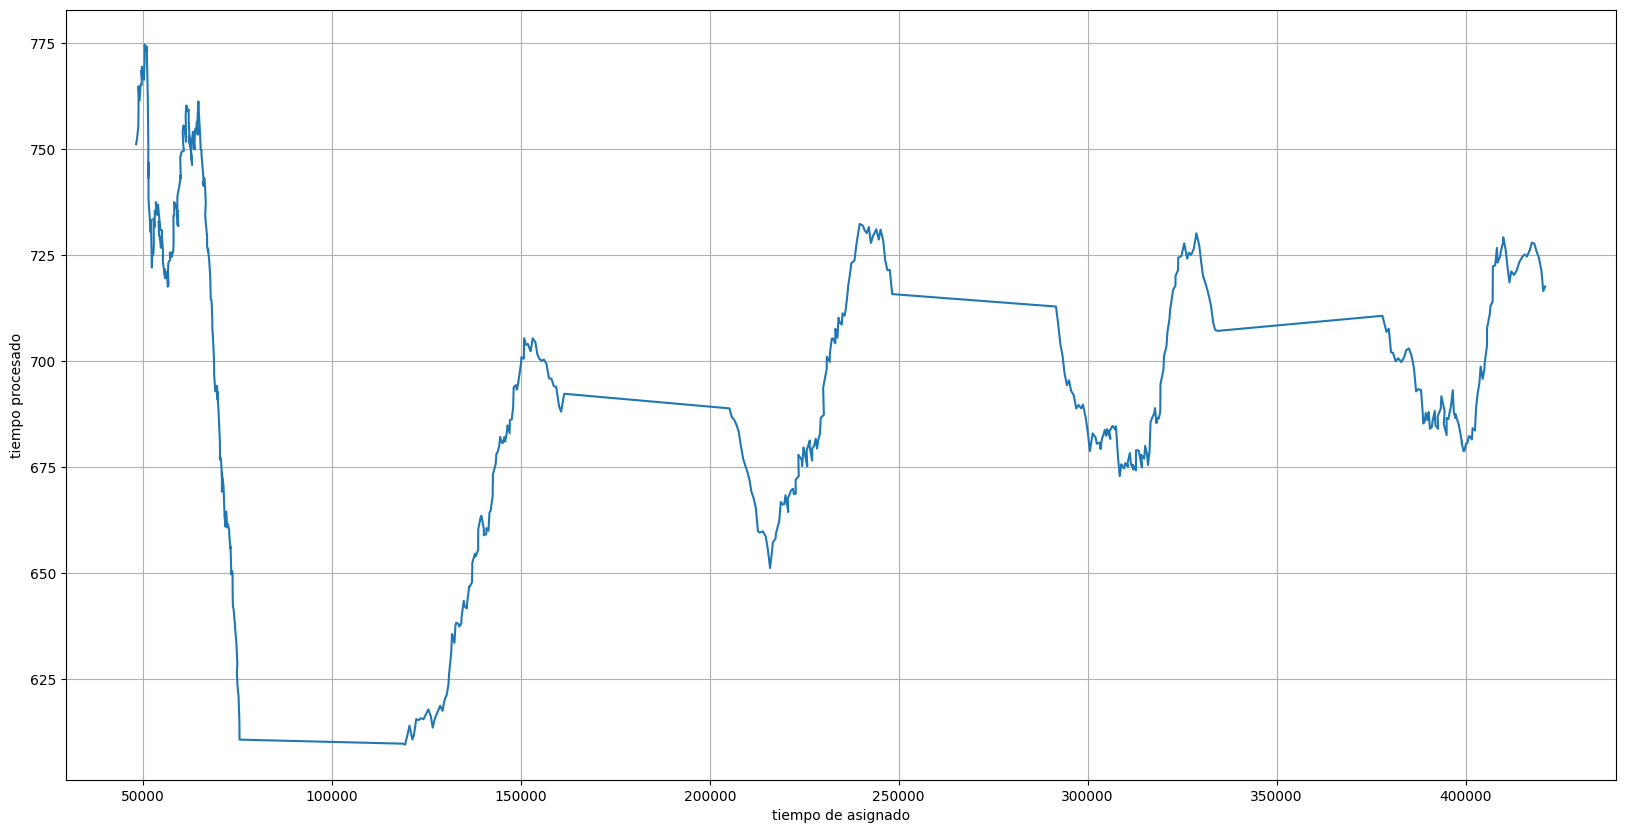

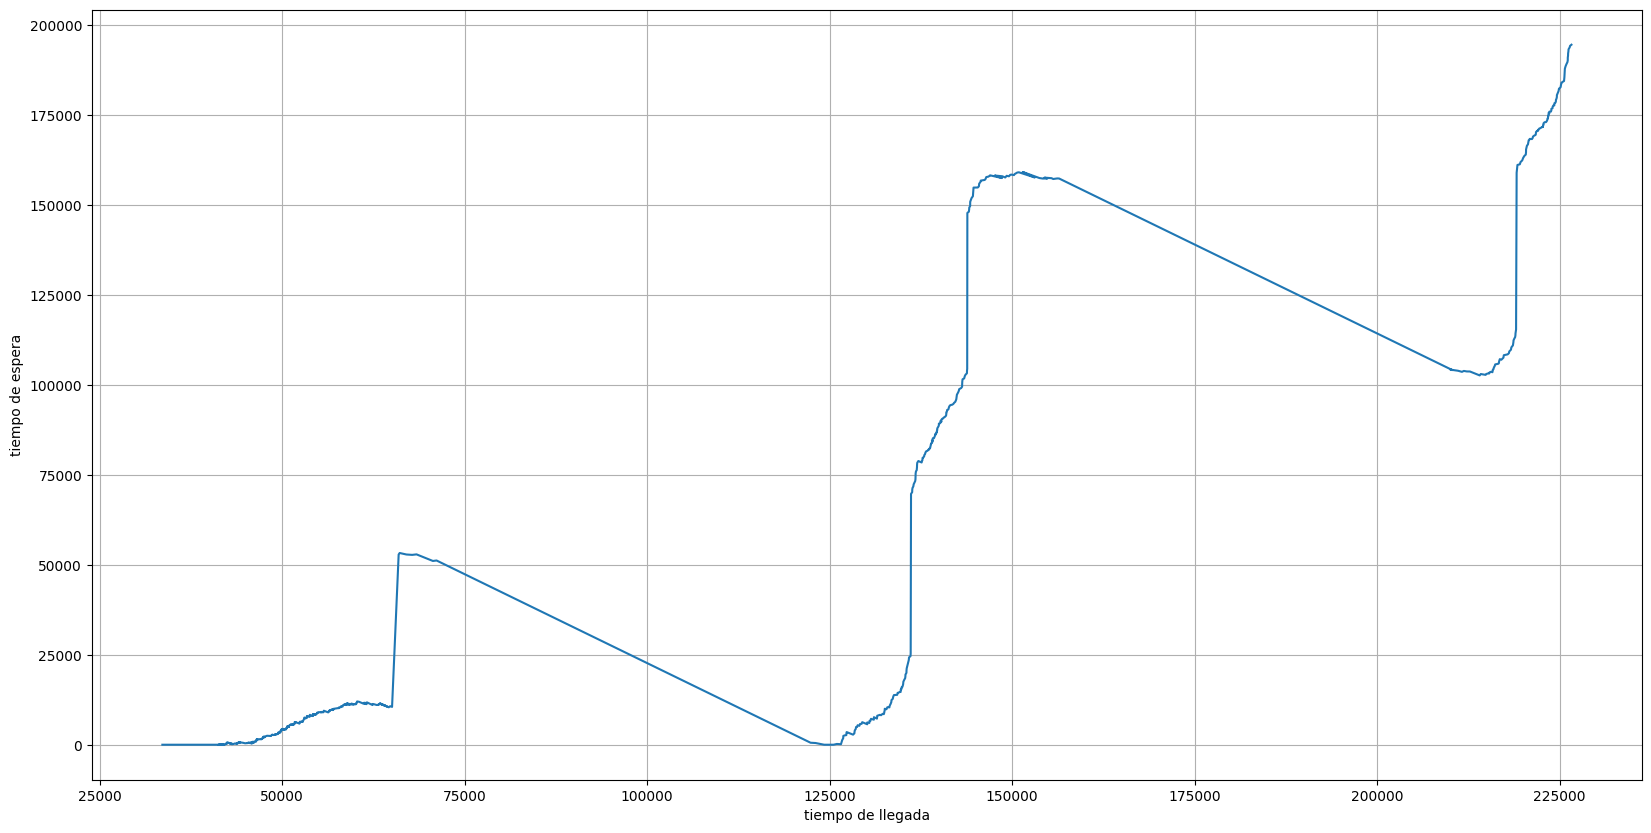

In [122]:
total_time = df['total_time']
total_time = total_time.rolling(window=1).mean()

processing_time = df['processing_time']
processing_time = processing_time.rolling(window=70).mean()

plt.plot(df["arrival_hour"],total_time )
plt.grid()
plt.ylabel("tiempo total")
plt.xlabel("tiempo de llegada")
plt.show()

plt.plot(df["assigned_time"],processing_time )
plt.ylabel("tiempo procesado")
plt.xlabel("tiempo de asignado")
plt.grid()
plt.show()

plt.plot(df["arrival_time"] , df["waiting_time"])
plt.ylabel("tiempo de espera")
plt.xlabel("tiempo de llegada")
plt.grid()
plt.show()


Vemos que saturo. *El tiempo total esta dominado por el tiempo en espera en lugar del tiempo de procesado*. Superando las 3 horas espera en el cuarto dia.

## El efecto del Manager en la saturacion

Podemos a la situacion anterior agregarle el manager para chequear que pasa con la saturacion.

El manager puede decidir actuar con distintos niveles de saturacion. Podemos probar con distintos niveles de saturacion. En lo que sigue dejamos fijo el promedio de camiones por dia en 250.

### Unbral bajo. 5 camiones por hora

En principio podemos probar con el manager actuando todo el tiempo, aumentando la cantidad de trabajadores y gates abiertas. Esto reducira el nivel de saturacion.

In [123]:
change_param("top_250_con_manager","threshold",5)
run("top_250_con_manager",f"top_250_con_manager")
df = read_out(f"top_250_con_manager")

df.head()

,id,arrival_time,assigned_time,out_time,nA,nB,nC,id_gate,extra_workers,arrival_hour_modulo,arrival_hour,total_time,processing_time,waiting_time
0,0.0,35051.2,35052.2,35610.2,39.0,50.0,33.0,1.0,0.0,9.736444,9.736444,559.0,558.0,1.0
1,1.0,35746.2,35747.2,36427.4,49.0,57.0,36.0,1.0,0.0,9.929500,9.929500,681.2,680.2,1.0
2,2.0,37929.1,37930.1,38541.8,47.0,53.0,47.0,1.0,0.0,10.535861,10.535861,612.7,611.7,1.0
3,3.0,38023.0,38024.0,38660.4,50.0,40.0,59.0,2.0,0.0,10.561944,10.561944,637.4,636.4,1.0
4,4.0,38128.6,38129.6,38732.7,54.0,47.0,58.0,3.0,0.0,10.591278,10.591278,604.1,603.1,1.0


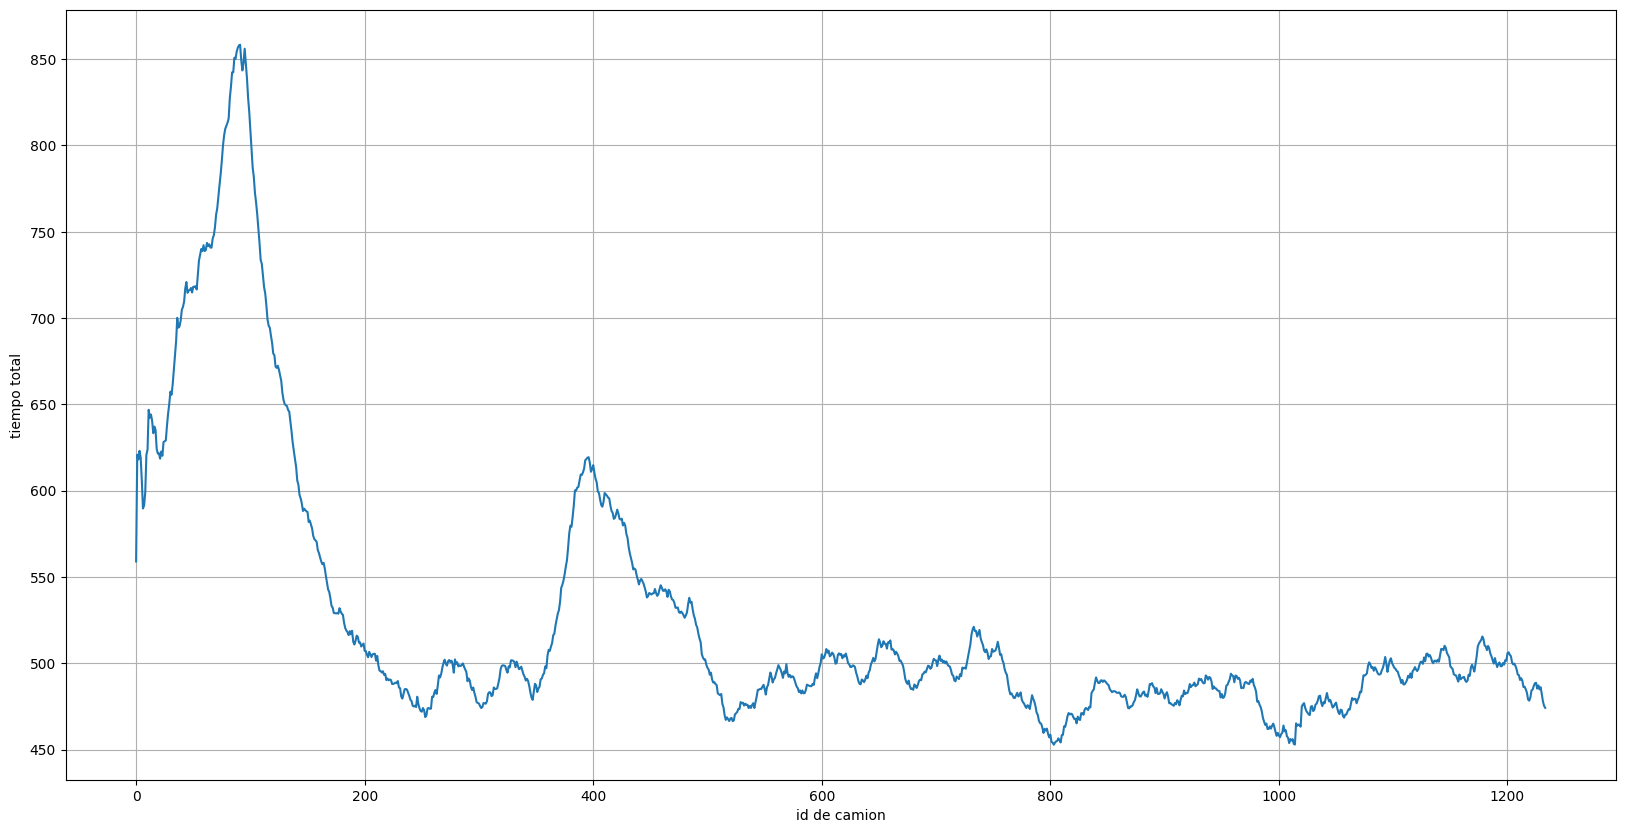

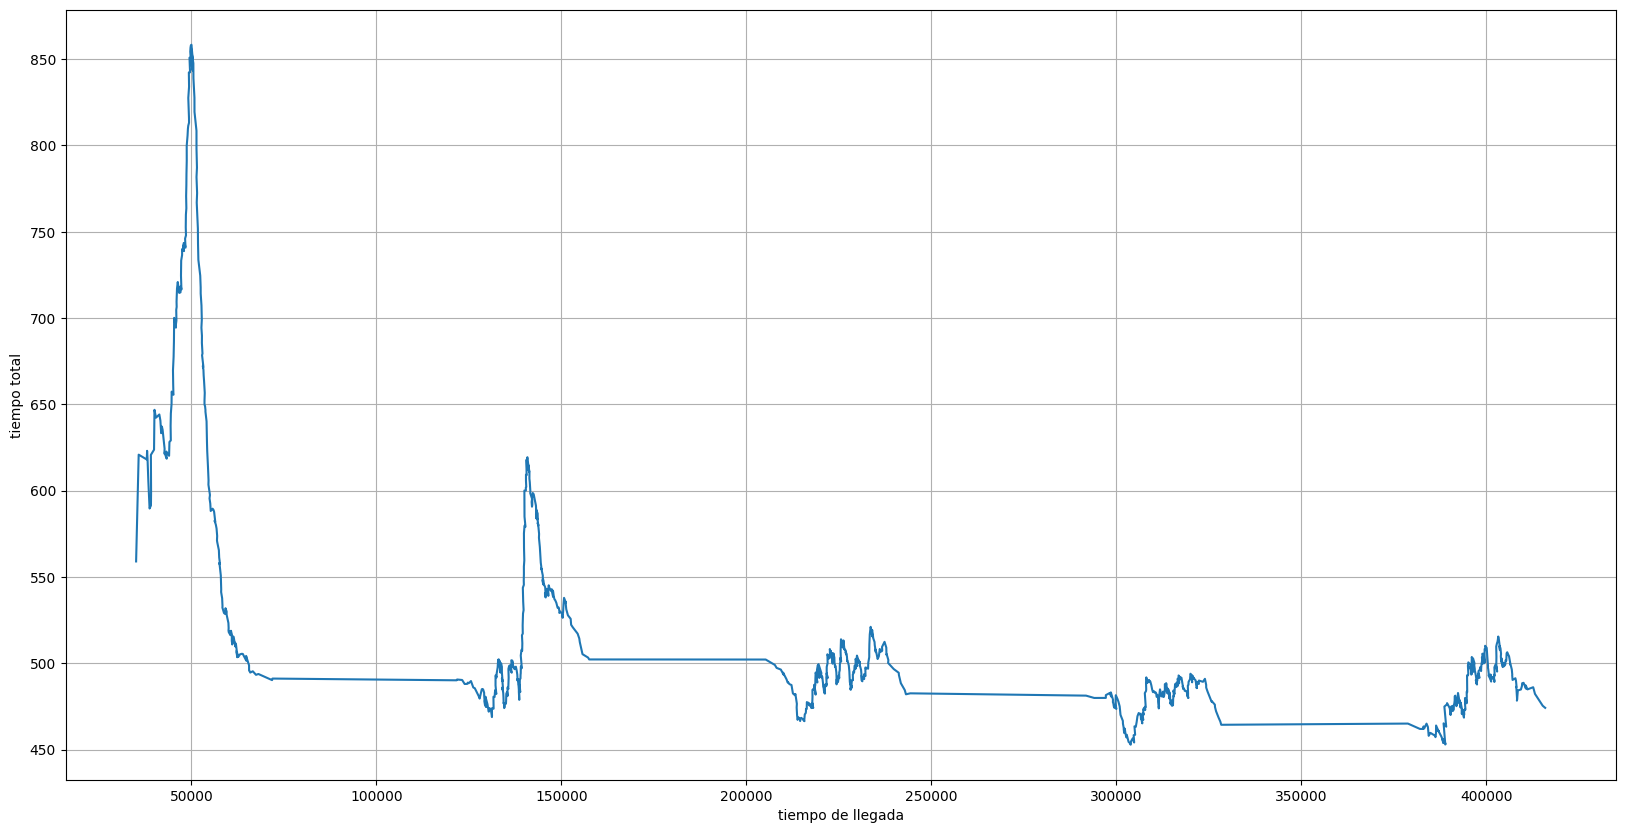

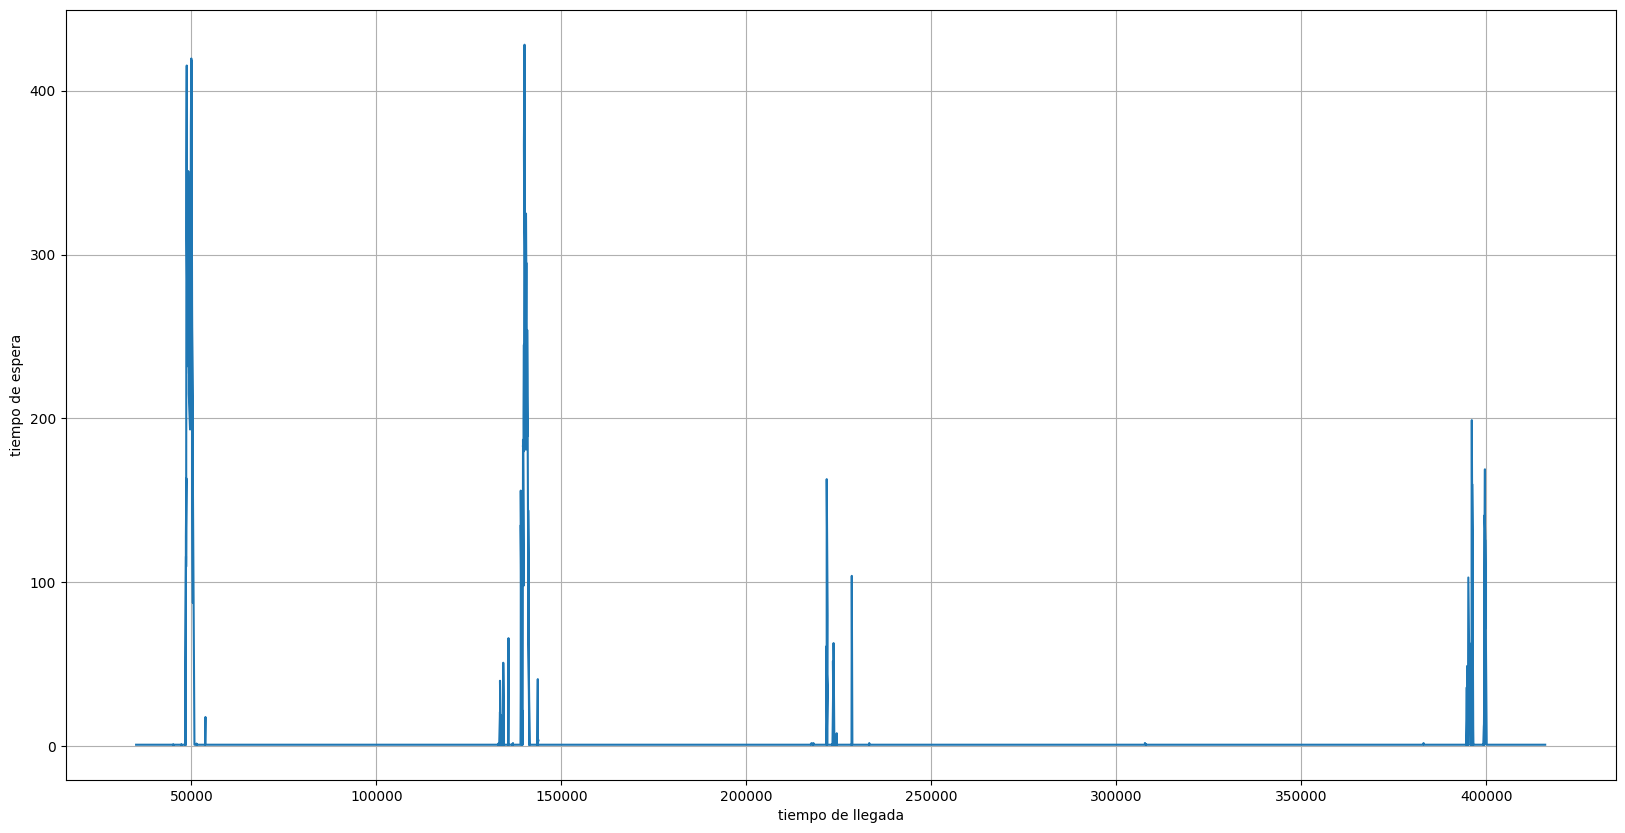

In [124]:
df.sort_values('arrival_time')

total_time = df['total_time']
total_time = total_time.ewm(com=40).mean()

plt.plot(total_time, )
plt.grid()
plt.xlabel("id de camion")
plt.ylabel("tiempo total")
plt.show()

plt.plot(df["arrival_time"],total_time )
plt.grid()
plt.ylabel("tiempo total")
plt.xlabel("tiempo de llegada")
plt.show()


plt.plot(df["arrival_time"] , df["waiting_time"])
plt.ylabel("tiempo de espera")
plt.xlabel("tiempo de llegada")
plt.grid()
plt.show()


Vemos que efectivamente evita la saturacion como esperabamos. Seria interesante ver como afecta el manager a la latencia del sistema. Las lineas rojas indican las señales del manager


In [31]:
with open("../data/top250trucksManager_Parallel.out") as f:
    lines = f.readlines()
    lines = list(filter(lambda x: "manager(03) / out2" in x, lines))
    lines = list(map(lambda x: x.split("/")[3].split(" ")[1], lines))
manager_calls = [time_to_secs(t) for t in lines]

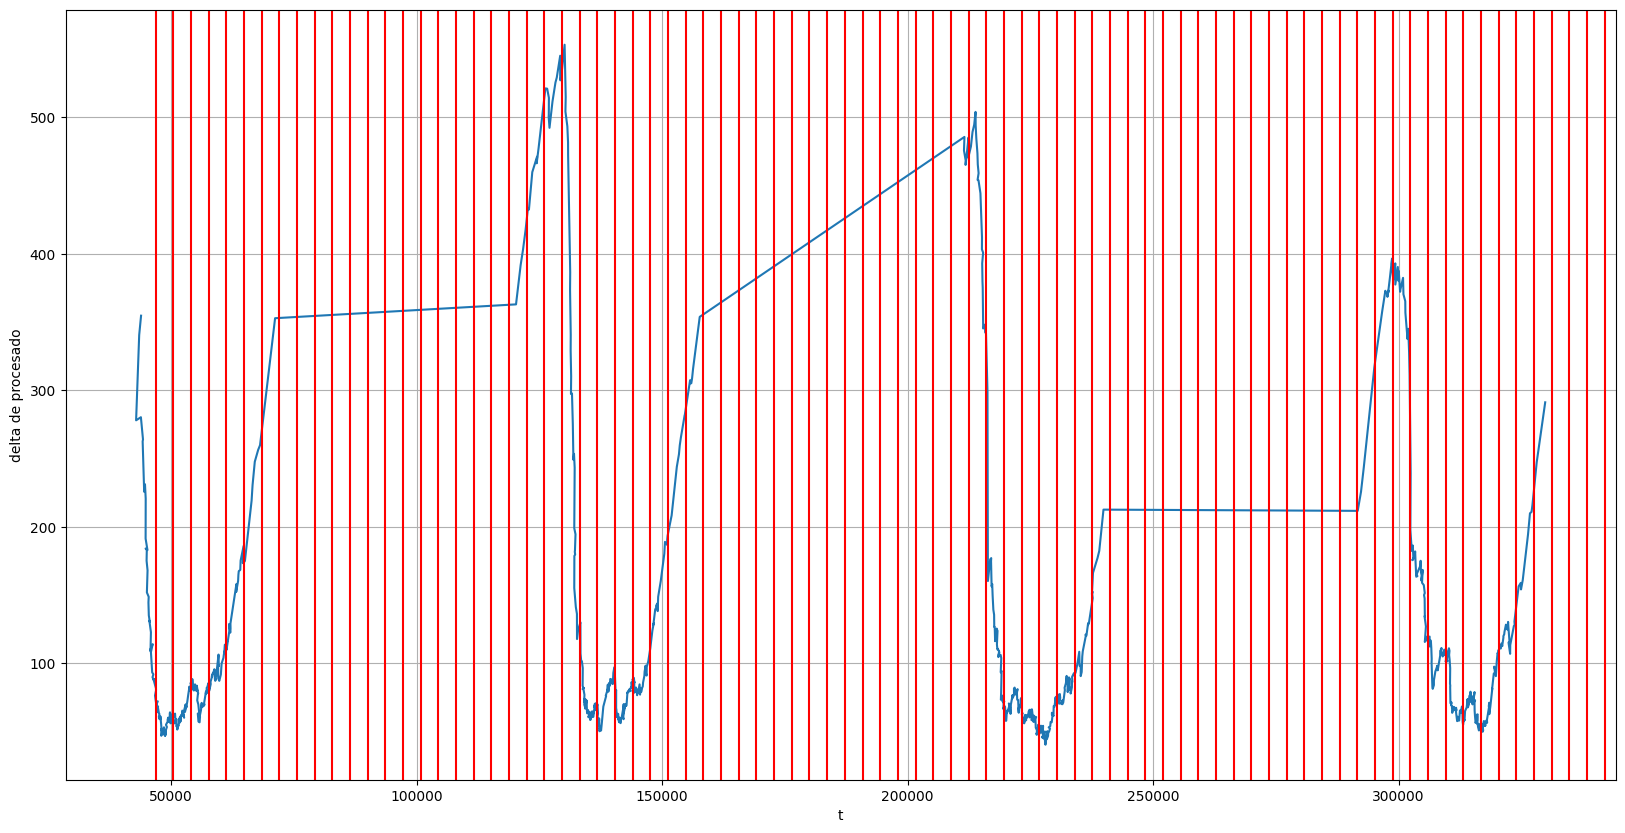

In [32]:
out_time = df["out_time"]
out_time = out_time.sort_values()
out_time = out_time.diff()
out_time = out_time[1:]

mask = out_time<10000
out_time = out_time[mask]
t = df["assigned_time"][1:]
t = t[mask]
out_time = out_time.rolling(window=30).mean()

plt.plot(t, out_time )
plt.ylabel("delta de procesado")
plt.xlabel("t")
plt.grid()


for t in manager_calls:
    plt.axvline(x = t, color = 'r')
plt.show()

Claramente se esta usando demasiado el manager y quizas subir el umbral puede evitar la saturacion sin tener que usarse tanto. En ultima instancia esto representaria un ahorro.

A continuacion mostramos la cantidad de trabajadores por boost usados para procesar cada paquete con un moving average.


Text(0, 0.5, 'workers extra')

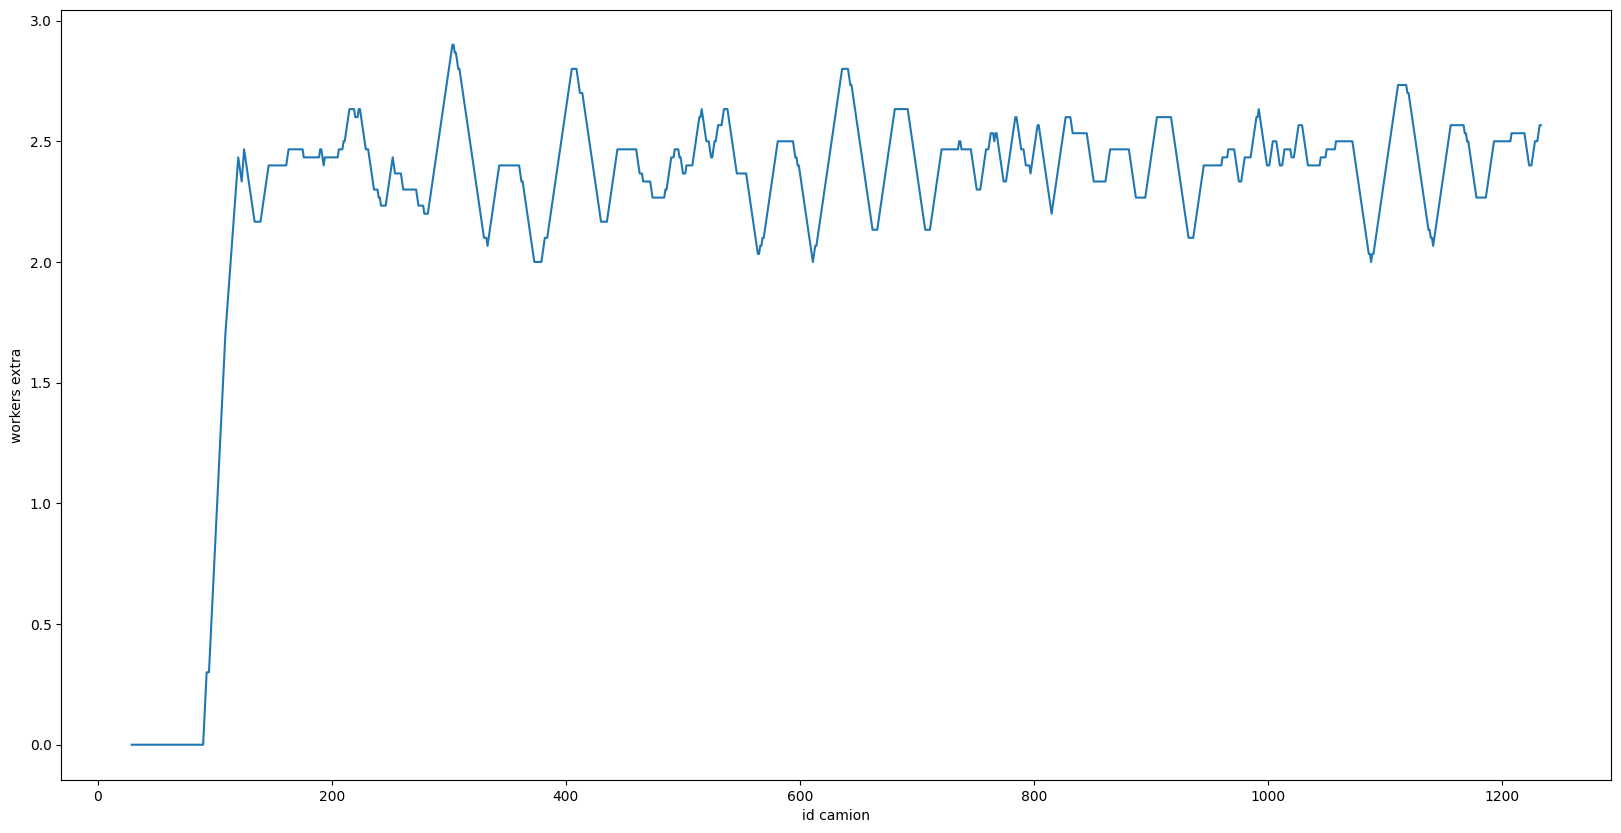

In [133]:
plt.plot(df["extra_workers"].rolling(window=30).mean())
plt.xlabel("id camion")
plt.ylabel("workers extra")

### Umbral medio. 10 camiones por hora

In [34]:
change_param("top_250_con_manager","threshold",10)
run("top_250_con_manager",f"top_250_con_manager")
df = read_out(f"top_250_con_manager")

df.head()

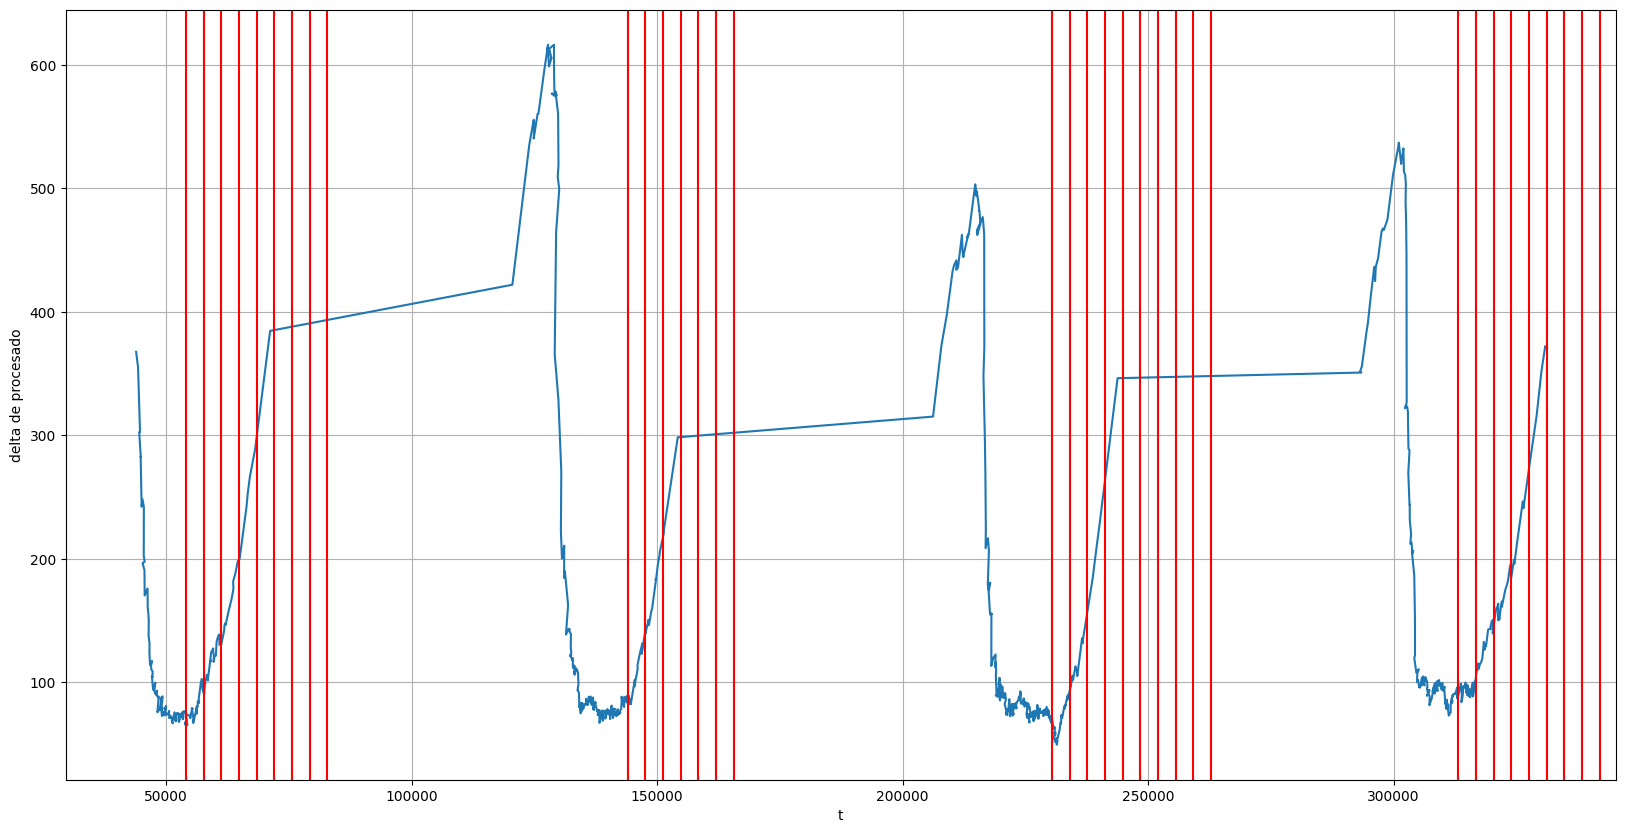

In [35]:
out_time = df["out_time"]
out_time = out_time.sort_values()
out_time = out_time.diff()
out_time = out_time[1:]

mask = out_time<10000
out_time = out_time[mask]
t = df["assigned_time"][1:]
t = t[mask]
out_time = out_time.rolling(window=30).mean()

plt.plot(t, out_time )
plt.ylabel("delta de procesado")
plt.xlabel("t")
plt.grid()


for t in manager_calls:
    plt.axvline(x = t, color = 'r')
plt.show()

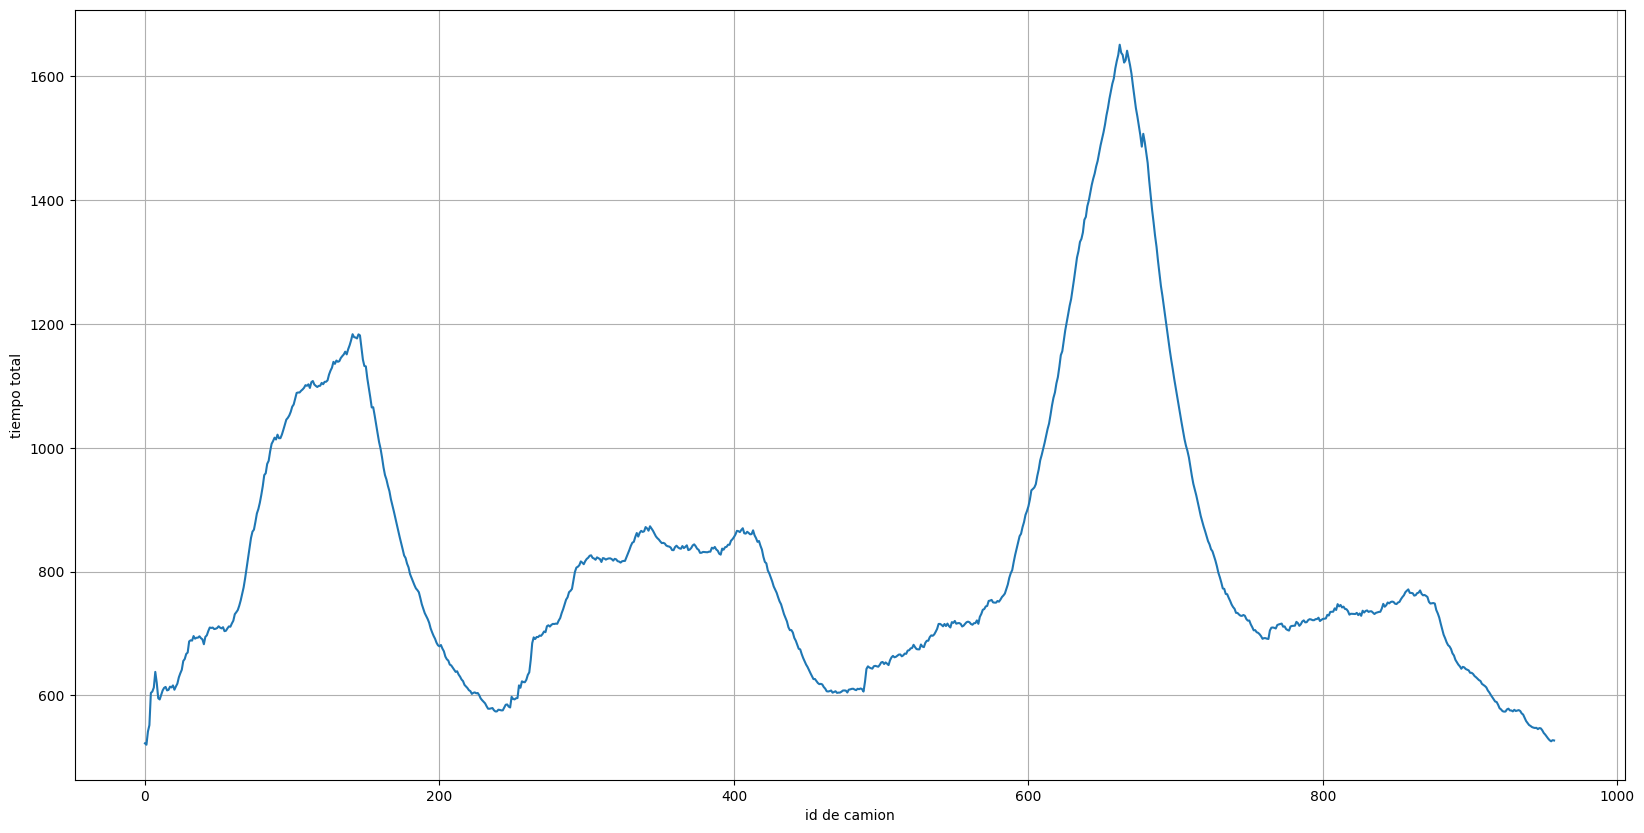

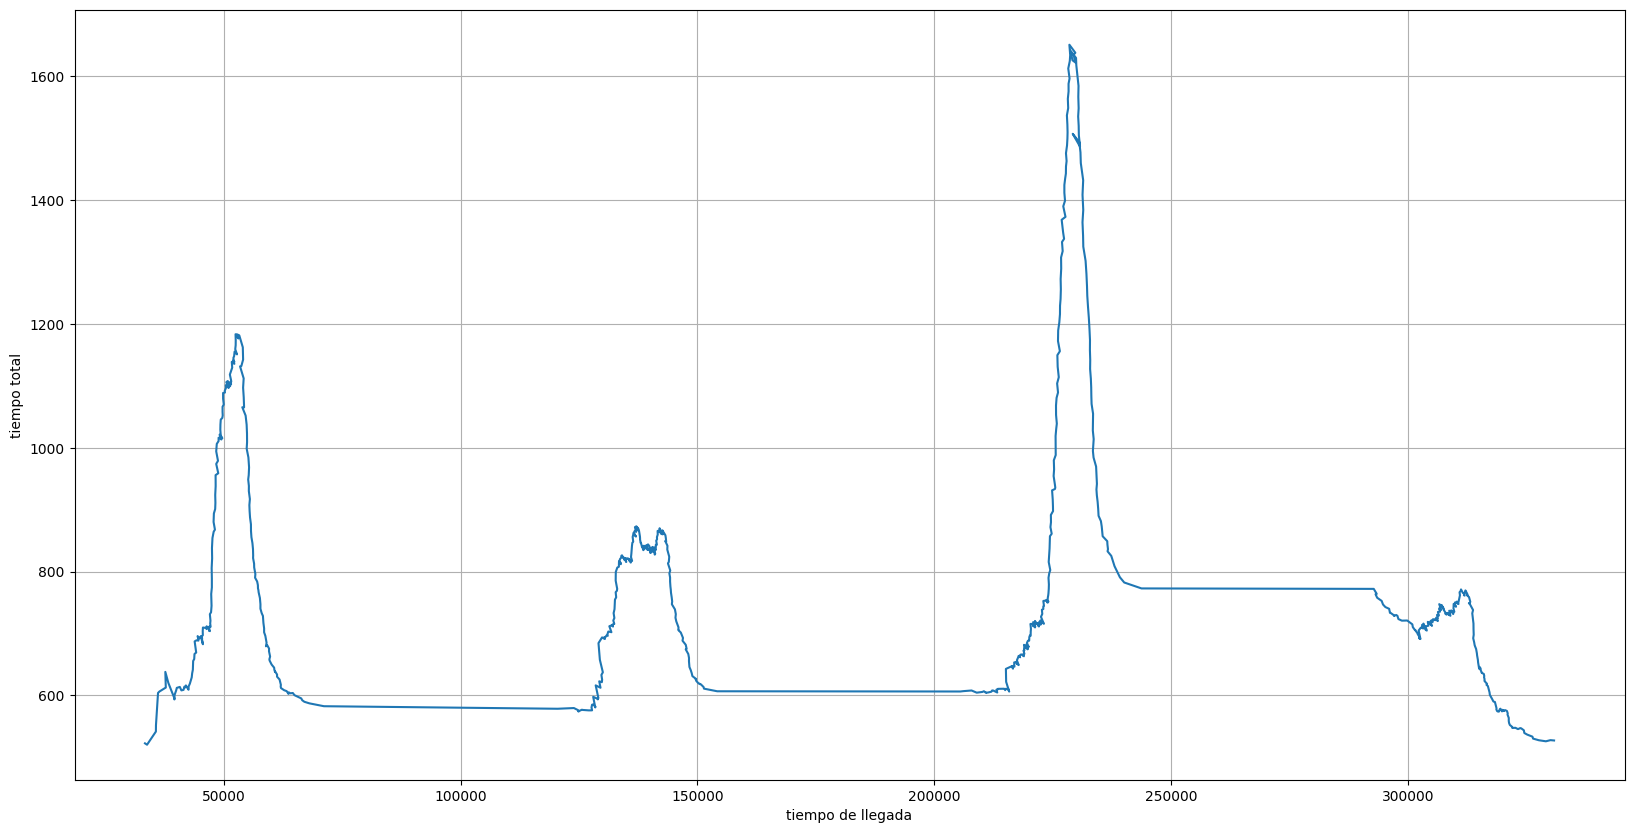

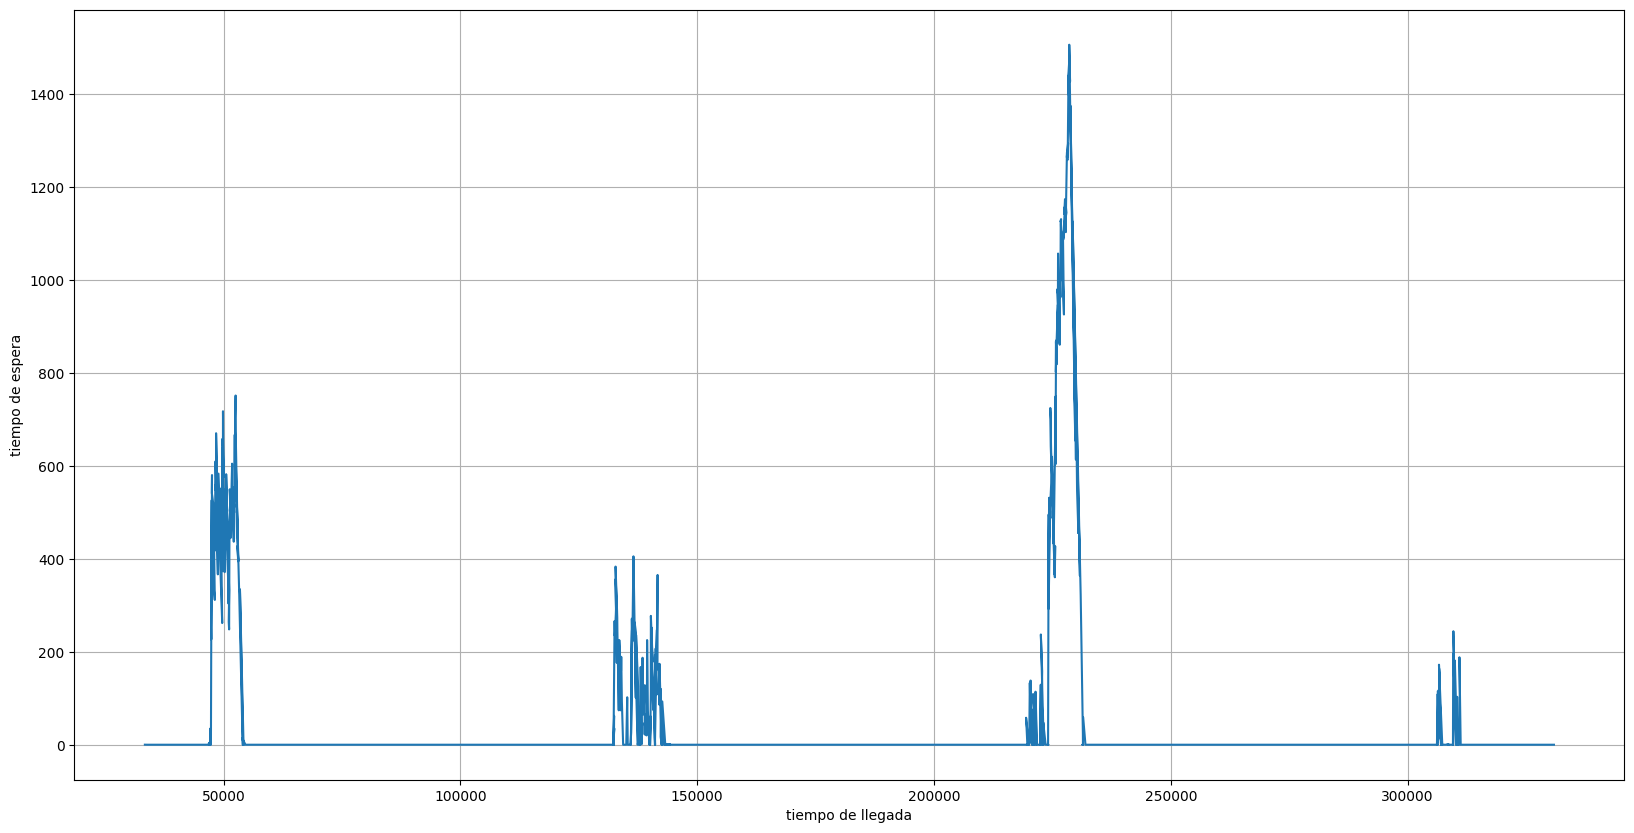

In [36]:
df.sort_values('arrival_time')

df["total_time"] = df["out_time"] - df["arrival_time"] 
df["waiting_time"] = df["assigned_time"] - df["arrival_time"] 
df["proccesing_time"] = df["out_time"] - df["assigned_time"] 

total_time = df['total_time']
total_time = total_time.ewm(com=40).mean()

plt.plot(total_time, )
plt.grid()
plt.xlabel("id de camion")
plt.ylabel("tiempo total")
plt.show()

plt.plot(df["arrival_time"],total_time )
#df.plot(x="arrival_time" , y="total_time",figsize=(20,10))
plt.grid()
plt.ylabel("tiempo total")
plt.xlabel("tiempo de llegada")
plt.show()


plt.plot(df["arrival_time"] , df["waiting_time"])
plt.ylabel("tiempo de espera")
plt.xlabel("tiempo de llegada")
plt.grid()
plt.show()


Vemos que con este umbral parece que el sistema todavia soporta la llegada de camiones aunque el maximo tiempo que un camion se encuentra en el sistema se duplico. En el siguiente grafico vemos la cantidad de trabajadores extras para cada camion. Notar que a diferencia del umbral anterior, no se estan usando trabajadores extra para todos los camiones por lo que resulta un ahorro.

Text(0, 0.5, 'workers extra')

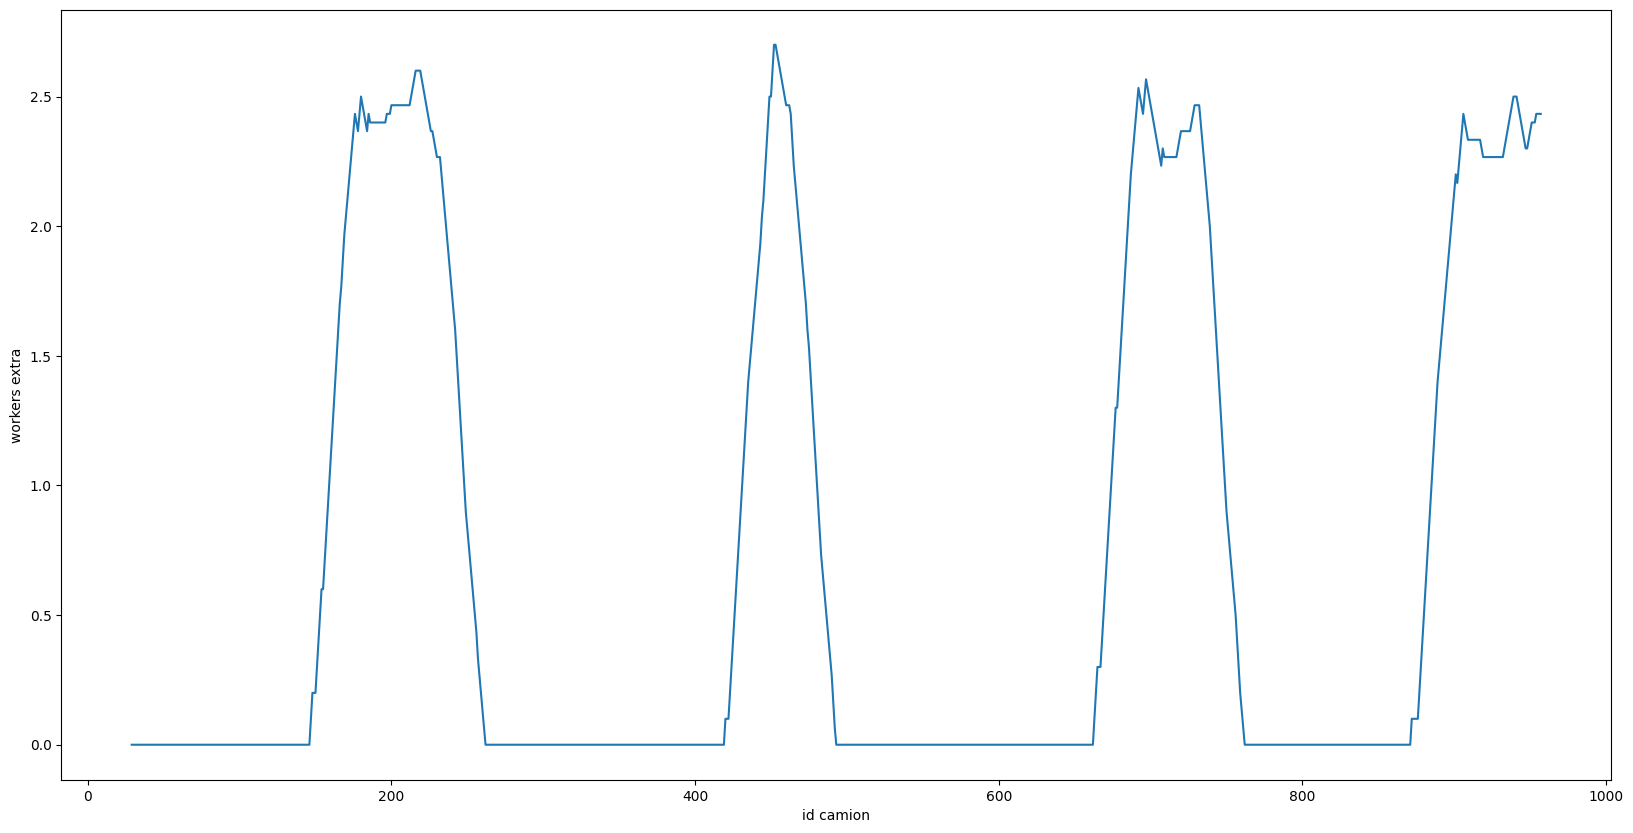

In [37]:
plt.plot(df["extra_workers"].rolling(window=30).mean())
plt.xlabel("id camion")
plt.ylabel("workers extra")

### Umbral alto. 12 camiones por hora

Podemos probar incrementar mas el umbral para hallar el punto correcto. Ahora cambiamos el umbral a 12 camiones por hora y vemos que el sistema satura aun con el manager.

In [38]:
with open("../data/top250trucks12Manager.out") as f:
    lines = f.readlines()
    lines = list(filter(lambda x: "out" in x, lines))
    lines = list(map(lambda x: x.split("[")[1].split("]")[0], lines))

df = pd.DataFrame([x.split(', ') for x in lines])
df.columns = ['id', 'arrival_time', "assigned_time", "out_time", "nA", "nB", "nC", 'id_gate', 'extra_workers']
df = df.astype(np.float64)

with open("../data/top250trucks12Manager_Parallel.out") as f:
    lines = f.readlines()
    lines = list(filter(lambda x: "manager(03) / out2" in x, lines))
    lines = list(map(lambda x: x.split("/")[3].split(" ")[1], lines))
manager_calls = [time_to_secs(t) for t in lines]

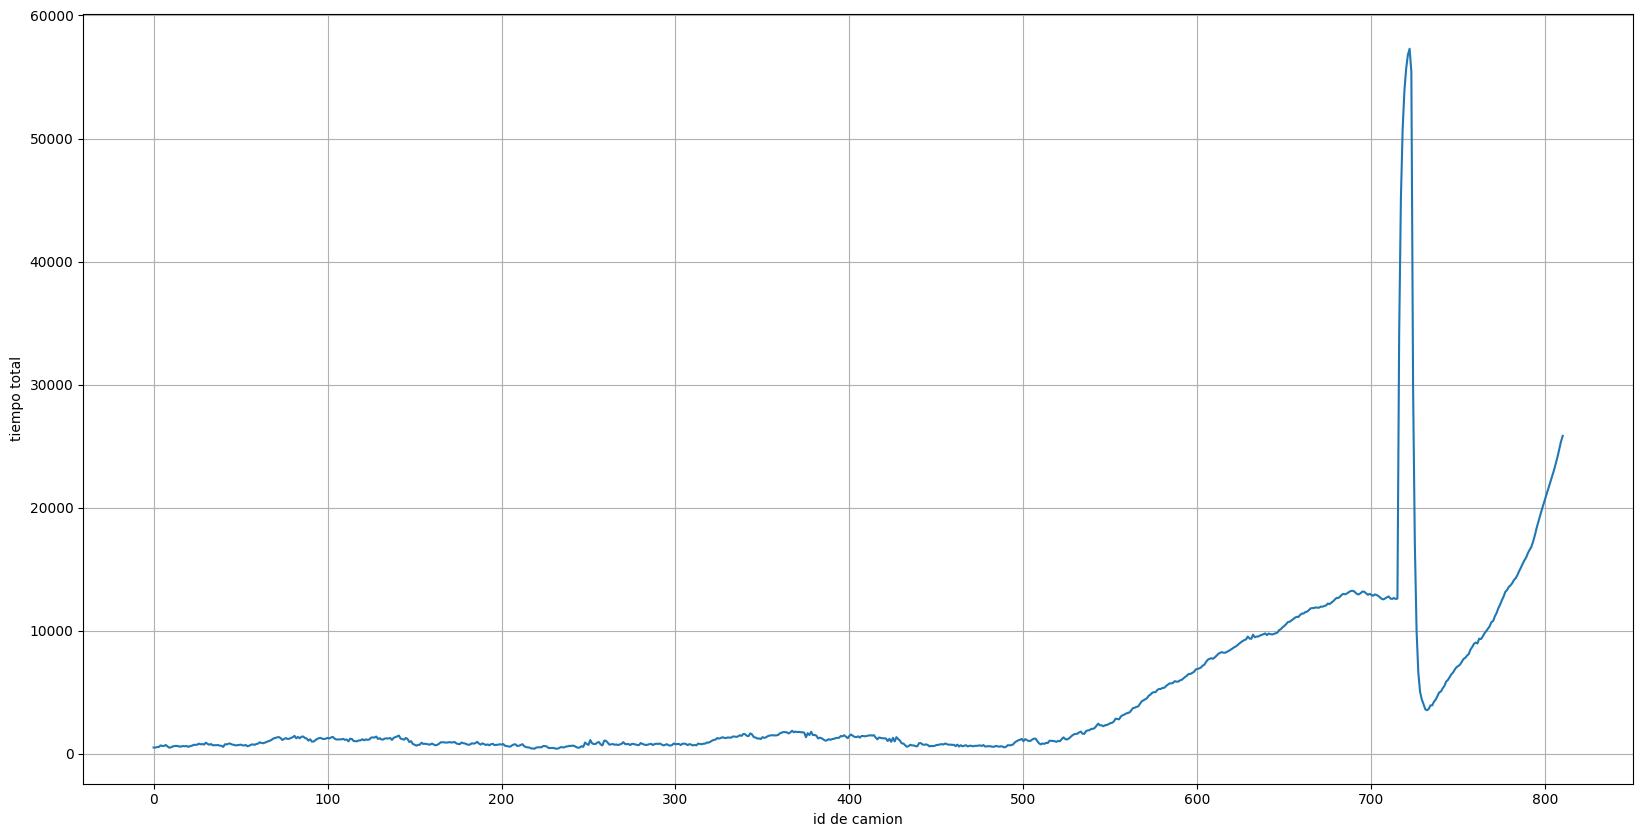

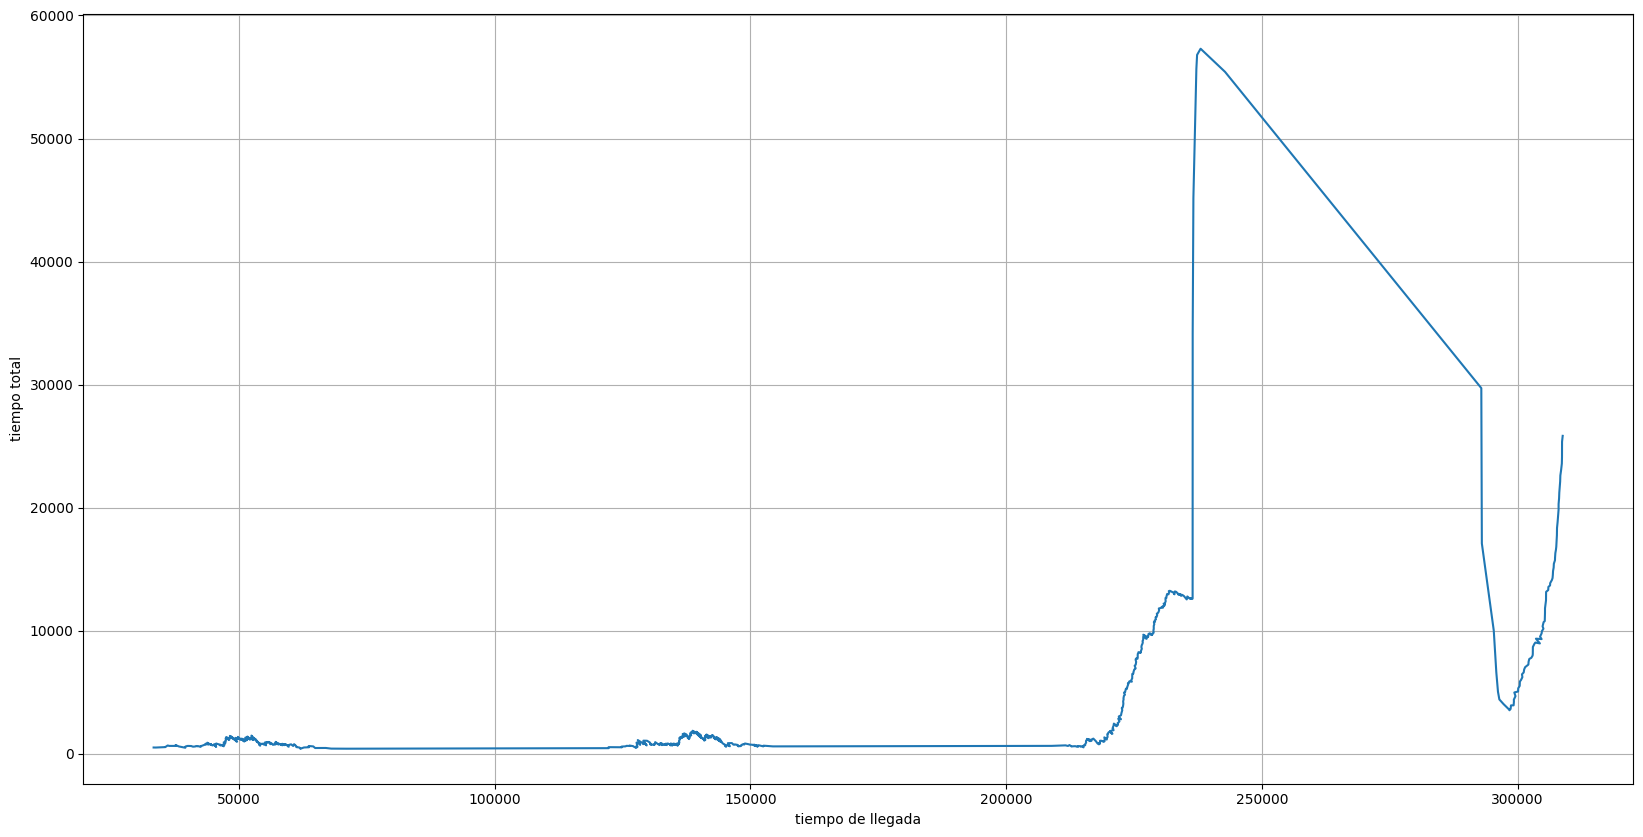

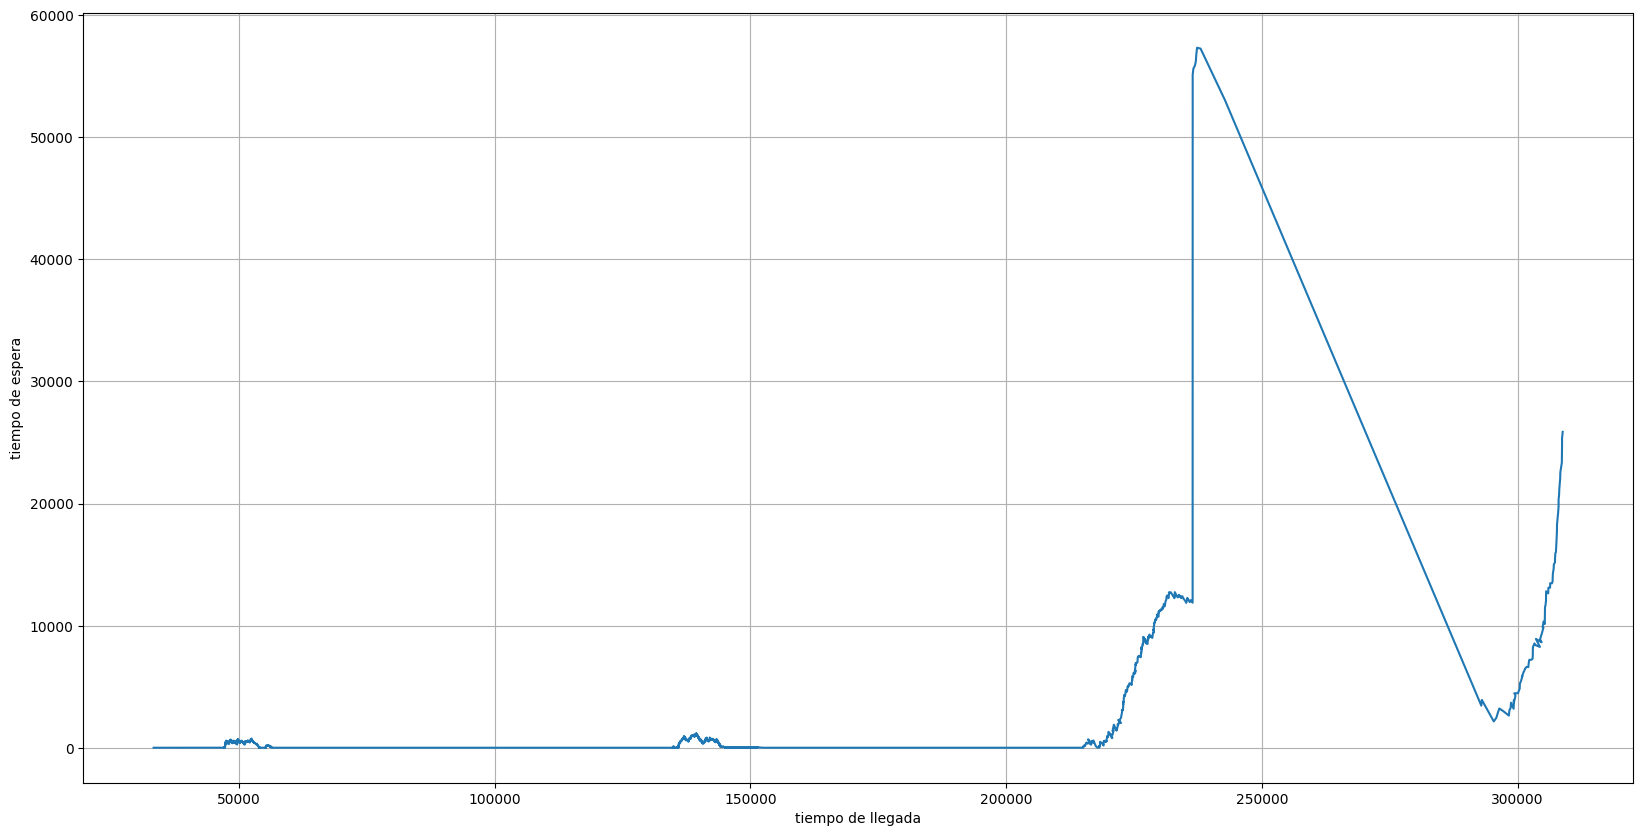

In [39]:
df.sort_values('arrival_time')

df["total_time"] = df["out_time"] - df["arrival_time"] 
df["waiting_time"] = df["assigned_time"] - df["arrival_time"] 
df["proccesing_time"] = df["out_time"] - df["assigned_time"] 

total_time = df['total_time']
total_time = total_time.ewm(com=1).mean()

plt.plot(total_time, )
plt.grid()
plt.xlabel("id de camion")
plt.ylabel("tiempo total")
plt.show()

plt.plot(df["arrival_time"],total_time )
#df.plot(x="arrival_time" , y="total_time",figsize=(20,10))
plt.grid()
plt.ylabel("tiempo total")
plt.xlabel("tiempo de llegada")
plt.show()


plt.plot(df["arrival_time"] , df["waiting_time"])
plt.ylabel("tiempo de espera")
plt.xlabel("tiempo de llegada")
plt.grid()
plt.show()


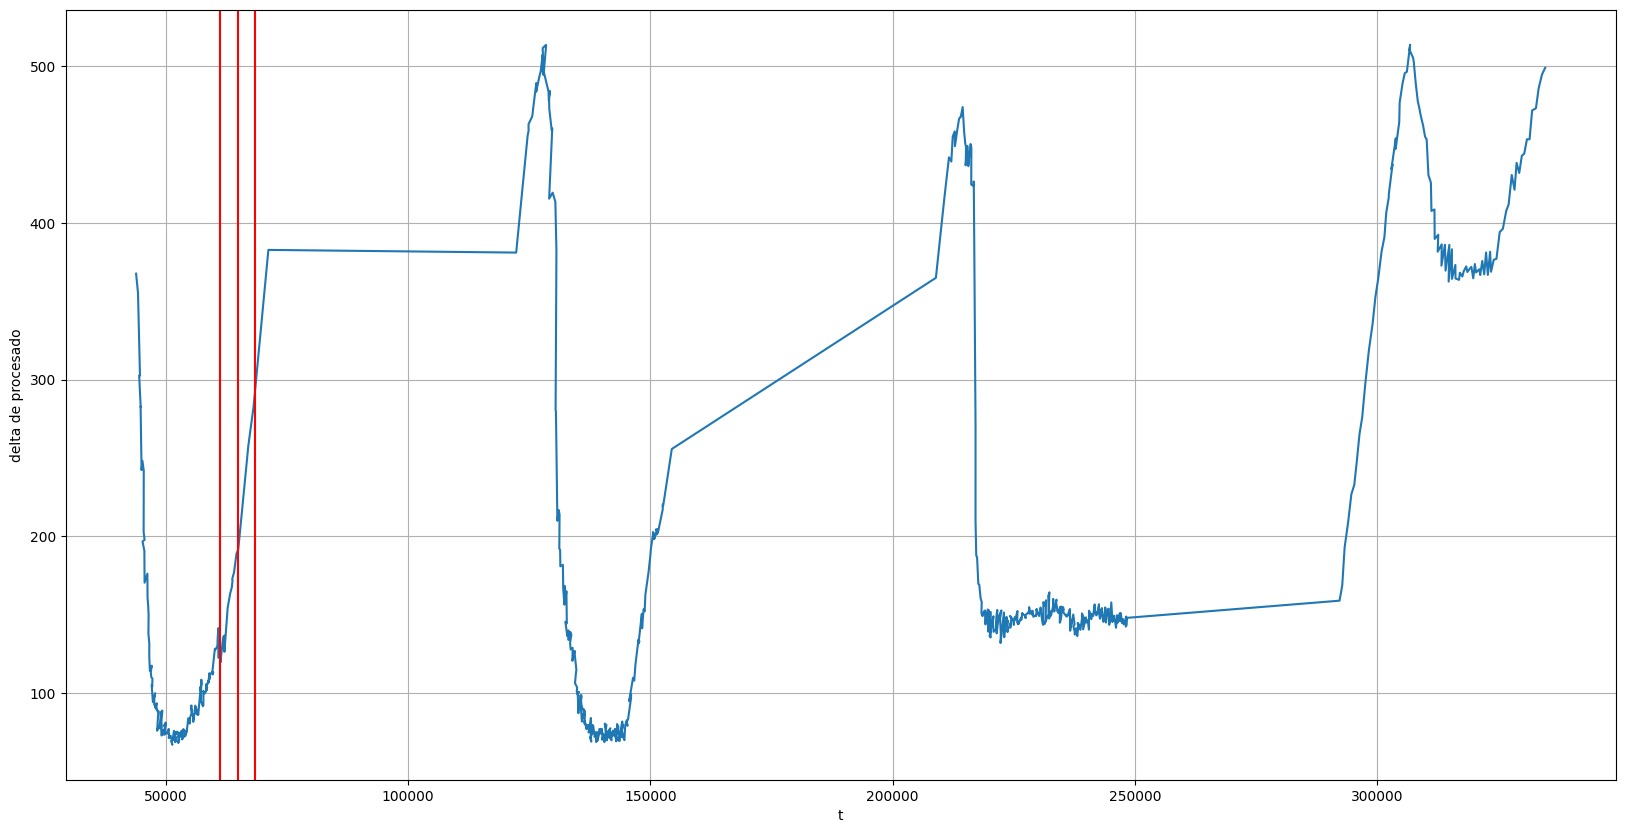

In [40]:
out_time = df["out_time"]
out_time = out_time.sort_values()
out_time = out_time.diff()
out_time = out_time[1:]

mask = out_time<10000
out_time = out_time[mask]
t = df["assigned_time"][1:]
t = t[mask]
out_time = out_time.rolling(window=30).mean()

plt.plot(t, out_time )
plt.ylabel("delta de procesado")
plt.xlabel("t")
plt.grid()


for t in manager_calls:
    plt.axvline(x = t, color = 'r')
plt.show()

## Clausurando gates

Podemos jugar a anular algunas gates y ver como cambia el comportamiento del sistema. Para esto desconectamos algunas de las gates de horario de 18 a 21. En estos experimentos mantenemos un promedio de 150 camiones por dia y un umbral del manager de 10 camiones por hora para actuar.

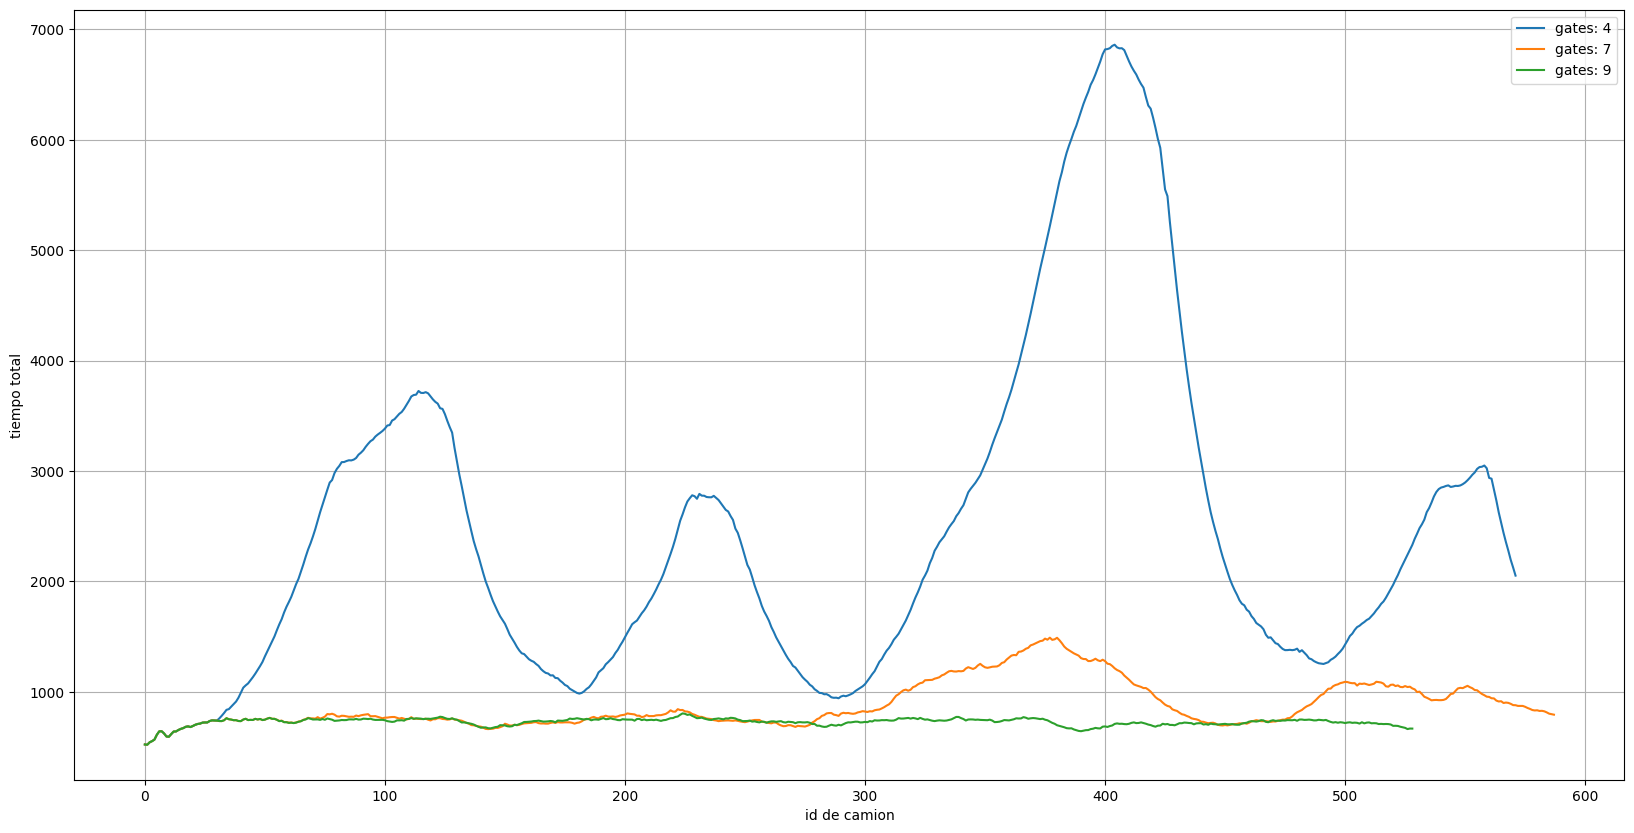

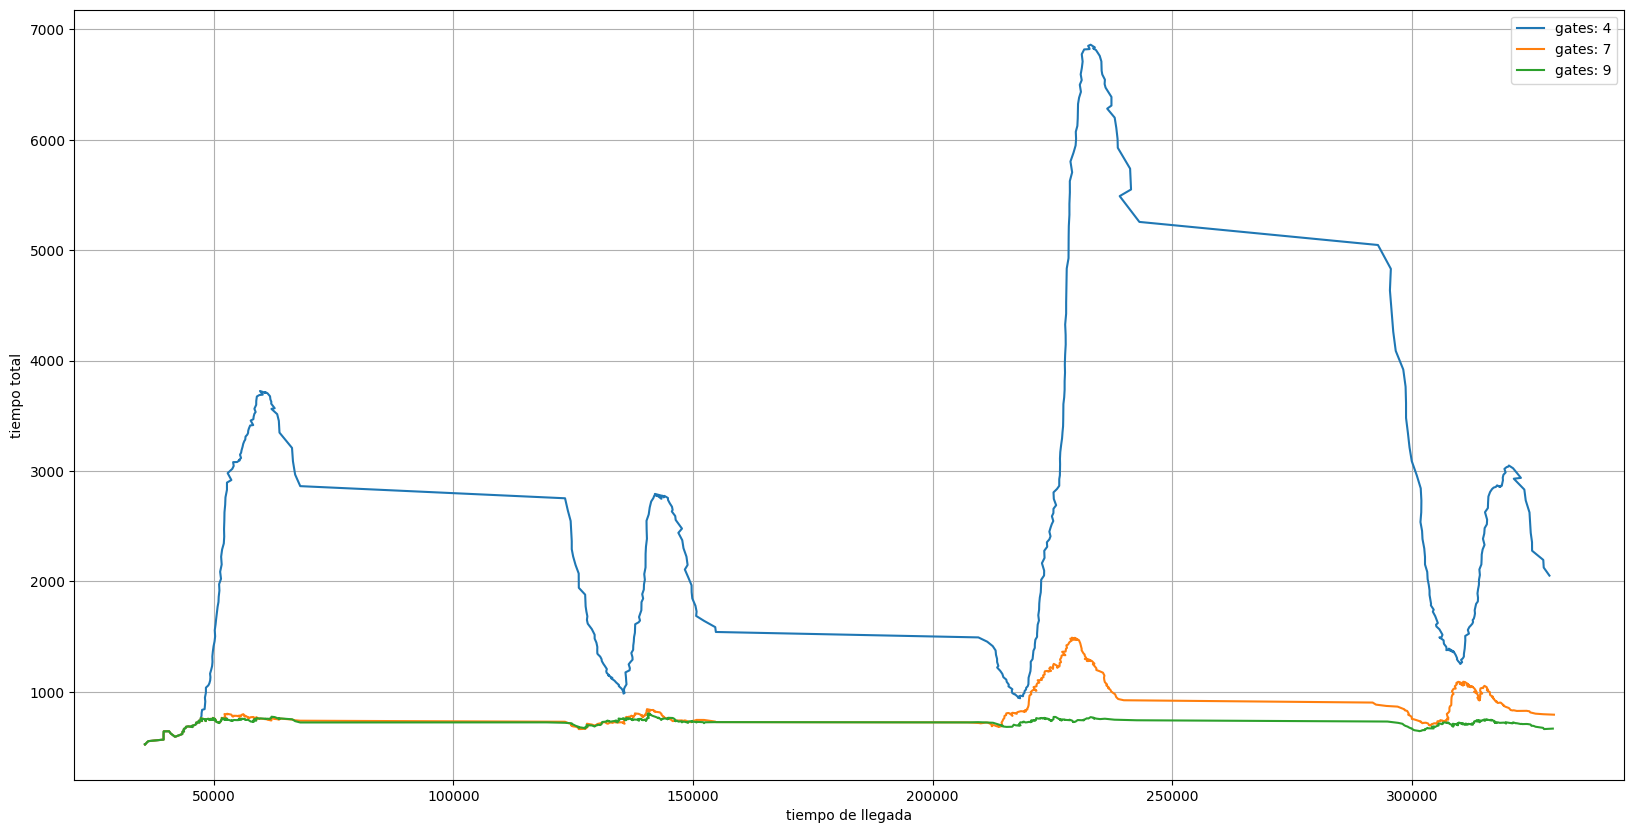

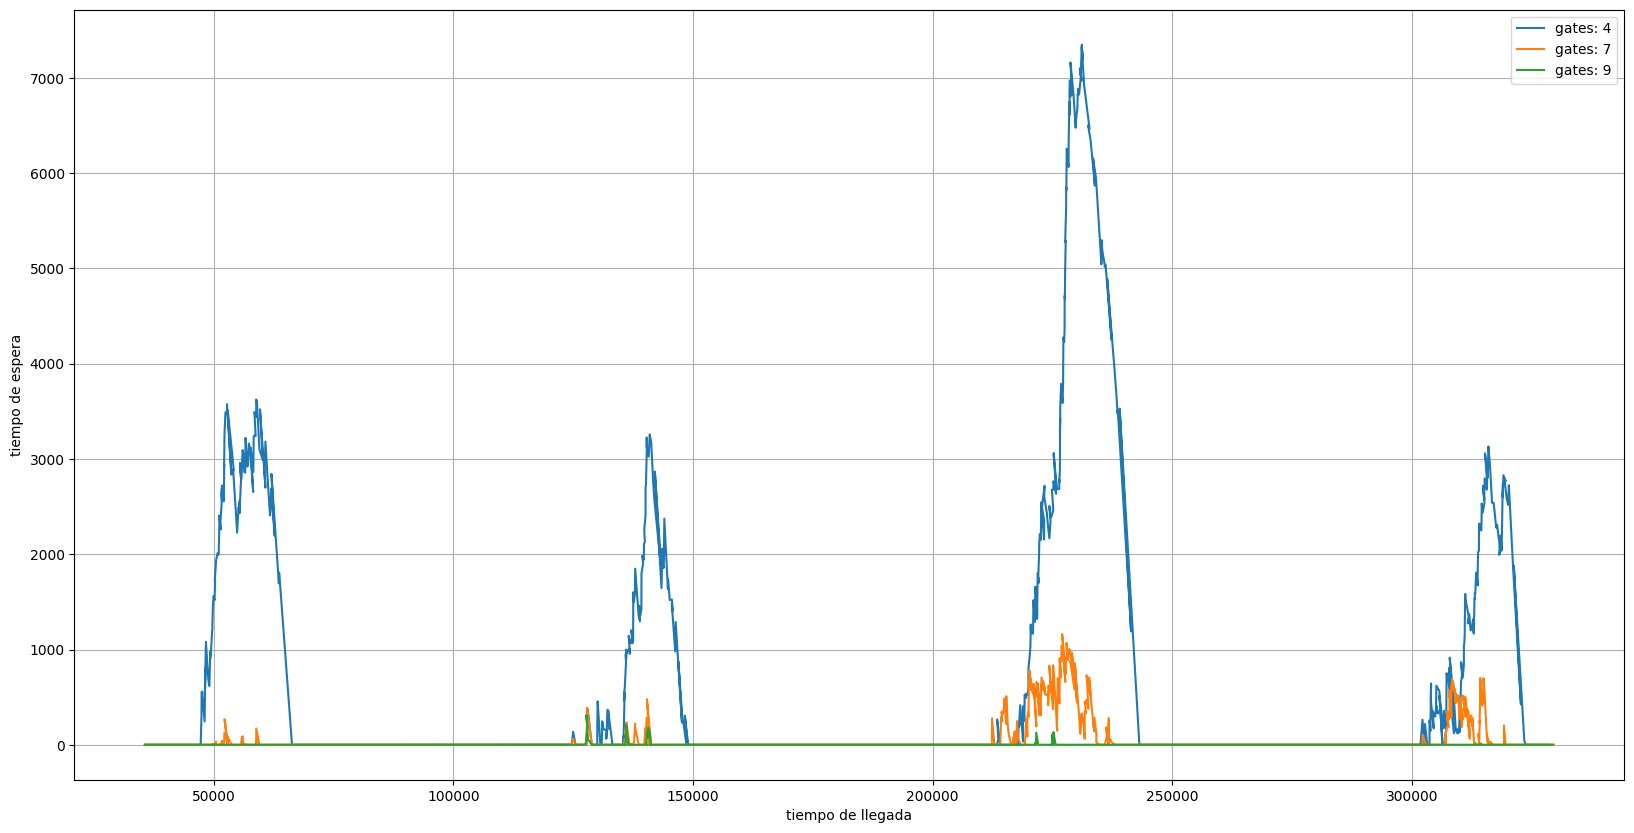

In [41]:
dfs = []
gates = ["4","7","9"]
for n in gates:
    file_name = "../data/top150trucks10Manager" + n+"gates.out"
    with open(file_name) as f:
        lines = f.readlines()
        lines = list(filter(lambda x: "out" in x, lines))
        lines = list(map(lambda x: x.split("[")[1].split("]")[0], lines))

        df = pd.DataFrame([x.split(', ') for x in lines])
    df.columns = ['id', 'arrival_time', "assigned_time", "out_time", "nA", "nB", "nC", 'id_gate', 'extra_workers']
    df = df.astype(np.float64)
    
    df["total_time"] = df["out_time"] - df["arrival_time"] 
    df["waiting_time"] = df["assigned_time"] - df["arrival_time"] 
    df["proccesing_time"] = df["out_time"] - df["assigned_time"] 
    dfs.append(df)


    

for n, d in zip(gates,dfs):
    total_time = d['total_time']
    total_time = total_time.ewm(com=20).mean()
    plt.plot(total_time, label= "gates: " + n)

plt.grid()
plt.xlabel("id de camion")
plt.ylabel("tiempo total")
plt.legend()
plt.show()

for n, d in zip(gates,dfs):
    total_time = d['total_time']
    total_time = total_time.ewm(com=20).mean()
    plt.plot(d["arrival_time"],total_time , label= "gates: " + n)
plt.grid()
plt.ylabel("tiempo total")
plt.xlabel("tiempo de llegada")
plt.legend()
plt.show()

for n, d in zip(gates,dfs):
    plt.plot(d["arrival_time"] , d["waiting_time"], label= "gates: " + n)
    
plt.ylabel("tiempo de espera")
plt.xlabel("tiempo de llegada")
plt.legend()
plt.grid()
plt.show()


Concluimos que, bajo estas condiciones, el sistema puede soportar tener menos gates y funcionar de manera aceptable. Con 7 gates el sistema parece ser lo suficientemente resiliente para mantener el tiempo de los camiones en un tiempo aceptable. Ya para 4 gates vemos un pico de casi 2 horas por lo que, si bien no parece llegar al punto de saturacion, puede ser un tiempo de espera demasiado alto.

Tambien resulta interesante ver el inpacto en la latencia del sistema.

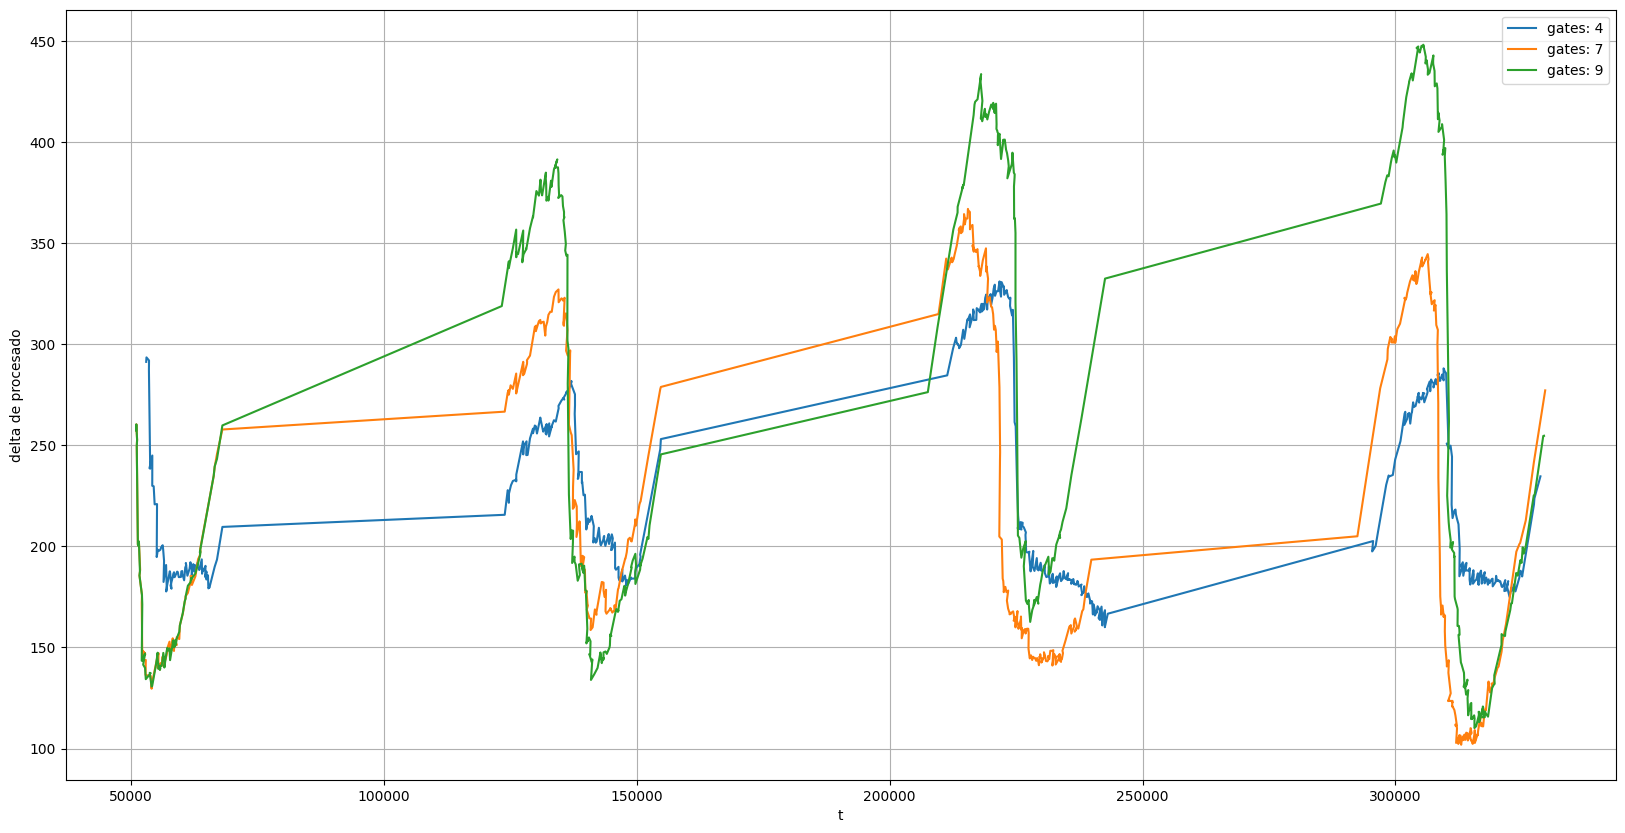

In [42]:
for n, d in zip(gates,dfs):

    out_time = d["out_time"]
    out_time = out_time.sort_values()
    out_time = out_time.diff()
    out_time = out_time[1:]

    mask = out_time<50000
    out_time = out_time[mask]
    t = d["assigned_time"][1:]
    t = t[mask]
    out_time = out_time.rolling(window=60).mean()

    plt.plot(t, out_time,label= "gates: " + n)
plt.ylabel("delta de procesado")
plt.xlabel("t")
plt.legend()
plt.grid()


Naturalmente vemos que al cerrar gates de periodo 18 a 21, vemos que los valles (correspondiente al periodo donde hay mas gates) son menos pronunciados. Es decir, baja menos la latencia del sistema en el periodo crucial donde estan llegando camiones con altas frecuencias. Curiosamente tambien observamos que los picos de latencia corresponden a sistemas con mas gates. ¿Quizas esto se deba a que no quedan mas camiones en cola y deben esperar a que lleguen mas?